In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
#Defining Machine parameters 
mach_mc = {"rs": 0.1729, "lq": 0.6986, "ld": 0.4347, "tmech":50.0, "psi_rm":0.9}
# mach_mc = {"rs": 0.009, "ld": 4.14, "lq": 4.21, "tmech":509.6, "psi_rm": 0.5}

# mach_mb = {"rs": 0.0185, "rr": 0.0132, "lh": 3.81, "ls": 3.9, "lr": 3.9, "tmech":397.31}

# mach_ma = {"rs": 0.015, "rr": 0.04, "lh": 2.31, "ls": 2.35, "lr": 2.35, "tmech":596.9}

# mach_BM = {"rs": 0.0426, "rr": 0.02113, "lh": 2.252, "ls": 2.252+0.078, "lr": 2.252+0.1052, "tmech":200.}

###  The Machine Parameters
We use machine dictionaries to calculate the various parameters used in space vector based machine model This function is called mach_para(dict)

In [3]:
def mach_para(mach):
    """Takes in the dictionary containing machine parameters (normalized)
       and returns various parameters that are used in space vector equations
       
       Takes arguement: machine dictionary
       """
    rs = mach["rs"]
    ld = mach['ld']
    lq = mach['lq']
#     ws = mach['ws']
#     sig= 1-(lh*lh)/(lr*ls)
#     kr=lh/lr
#     sigls=sig*ls
#     tr=lr/rr
#     rk=(rs+(kr)*(kr)*rr)
#     tk=sigls/(rs+(kr)*(kr)*rr)
    tmech = mach['tmech']
    psi_rm = mach['psi_rm']
#     print("lh = {0:1.3f}".format(lh))
#     return rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech
    return rs, ld, lq, tmech, psi_rm

In [4]:
mach_para(mach_mc)

(0.1729, 0.4347, 0.6986, 50.0, 0.9)

### PMSM Dynamics
#### Building the Dynamic Model of a PMSM in the d-q Coordinate
To model a PMSM, two state variables are chosen, which are $i_{s}$ and $\omega_{s}$. The $i_{s}$ can be further decomposed to $i_{sd}$, $i_{sq}$ in the permanant magnetic field since it is a complex space vector. The differential equations of these vectors are given as:

\begin{align}
\frac{di_{sd}}{d\tau}&= -\frac{r_{s}}{l_{d}}i_{sd} + \omega_{s} \frac{l_q}{l_d}i_{sq} + \frac{v_{sd}}{l_d}\\
\frac{di_{sq}}{d\tau}&= - \omega_{s} \frac{l_d}{l_q}i_{sd} -\frac{r_{s}}{l_{q}}i_{sq}  - \omega_{s} \frac{\psi_{r,m}}{l_q} + \frac{v_{sq}}{l_q}\\
\frac{d\omega_s}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_L\right], m_e = \psi_{r,m}i_{sq}+(l_d-l_q)i_{sd}i_{sq}
\end{align}


In [5]:
#Induction machine 5x5 dynamic model 

def IM_dynstep(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
    ws = X[2] # w
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_imstep(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[1][0]*(-w_s*psi_rm+u2))
    dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)
#     print(A[1][0],A[1][1],A[1][2],A[1][3],B[4][0])
#     dx0dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*x2 + A[0][3]*x3*x4 + A[0][4]*x4 + B[0][0]*u1)
#     dx1dt = (A[1][0]*x0 + A[1][1]*x1 + A[1][2]*x2*x4 + A[1][3]*x3 + A[1][4]*x4 + B[1][0]*u2)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dx2dt = (A[2][0]*x0 + A[2][1]*x1 + A[2][2]*x2 + A[2][3]*x3*x4 + A[2][4]*x4 + 0)
#     dx3dt = (A[3][0]*x0 + A[3][1]*x1 + A[3][2]*x2*x4 + A[3][3]*x3 + A[3][4]*x4 + 0)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dwxdt = rate
    return [dx0_dt,dx1_dt,dx2_dt]


def mach_imstep(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
    a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
    a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
    a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
    b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
    c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0

    A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
    B = ([b11], [b21], [b31])
    C = ([c11, c22, c33])
    D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [6]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]
    

In [7]:
#Function for rotor angle integration 
# d\delta/dt = w

def rotorangle(X,t,params):
    del0 = X
    w = params
    ddel0dt = w
    return ddel0dt

In [8]:
def PIcon(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    return y2

def PIconwithLim(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti, uplim, dwnlim = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
#     y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    yx = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    if (yx > uplim):
        yx = uplim
    elif (yx < dwnlim):
        yx = dwnlim
    y2 = yx
    return y2

In [9]:
# # testing block:
# TA,TB,TC,TD,tm = mach_imstep(mach_mc, params)
# print(TA, TB, TC, TD, tm)
# # print('kr = {0:3.3f}.'.format(kr))

## 1. System Dynamics without Control

In [10]:
#Setting up the simulaton for rotor model
# We will use for loop for simulation 
rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3

tend = 20*2*np.pi
tstart = 0.0
delta_t = 0.01
n = 100000
# n2 = int(100*2*np.pi/0.01)
ws = -0.5
mL = 0.0
Tta = np.arange(tstart, tend,delta_t)
# Tta = np.linspace(tstart, tend, n2)
#delta_t = Tta[1] - Tta[0]
usd = np.zeros(len(Tta))
usq = np.zeros(len(Tta))
sol1 = np.zeros((len(Tta),3))
# sol2 = np.zeros((len(Tta),2))
# FCangle = np.zeros(len(Tta))
# Field coordinate currents
cosdelta = np.zeros(len(Tta))
sindelta = np.zeros(len(Tta))
isd = np.zeros(len(Tta))
isq = np.zeros(len(Tta))
eid = np.zeros(len(Tta))
eiq = np.zeros(len(Tta))
w = np.zeros(len(Tta))

# psird = np.zeros(len(Tta))
# psirq = np.zeros(len(Tta))

# # Initializing reference values for isd and isq:
# isdrefval = -0.1
# isdref = np.zeros(len(Tta))
# isqref = np.zeros(len(Tta))

# isqref1 = 0.0
# isqref2 = 0.8
# isqref3 = -0.35
# for ii in range(len(Tta)):
#     isdref[ii] = 0.0
#     if (Tta[ii]>=10*2*np.pi):
#         isqref[ii] = isqref3
#         isdref[ii] = -isdrefval
#     elif(Tta[ii]>=1*2*np.pi):
#         isqref[ii]=isqref2
#         isdref[ii] = isdrefval
#     else:
#         isqref[ii]=isqref1

me = np.zeros(len(Tta))
x0 = [0,0, ws] # isd, isq, ws
y0 = [1.0,0]

kpd = ld*1
Tid = 25.0e1

kpq = lq*2
Tiq = 25.0e1

Kparamsd = [kpd,Tid]
Kparamsq = [kpq,Tiq]

for ii in range(len(Tta)):
#     #Start controller after first step
#     if ii>=0:
#         eid[ii] = isdref[ii-1] - isd[ii-1]
#         PIed = [eid[ii],eid[ii-1]]
#         usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#         eiq[ii] = isqref[ii-1] - isq[ii-1]
#         PIeq = [eiq[ii],eiq[ii-1]]
#         usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)
#         usd[ii] = 0
#         usq[ii] =.0001
    if ws>=1.0:
        a = 1.0
    else: 
        a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
#     usa[ii] = usd[ii-1]*cosdelta[ii-1] - usq[ii-1]*sindelta[ii-1]
#     usb[ii] = usq[ii-1]*cosdelta[ii-1] + usd[ii-1]*sindelta[ii-1]

    params = [usd[ii], usq[ii],w[ii], ws]
    sol1a = odeint(IM_dynstep,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
    sol1[ii]= sol1a[-1]
#     display(sol1a[-1])
    x0 = sol1a[-1]
#     me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
#     paramsw = [me[ii],0.0,tmech]
#     sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
#     y0 = sol2a[-1]
#     sol2[ii] = sol2a[-1]
#     #Rotor angle using internal angle
#     FCangle[ii] = sol2[ii][1]
#     gamma[ii] = sol2[ii][1]
#     w[ii] = sol2[ii][0]
#     #using resolver output
# #     FCangle[ii] = sol2[ii]
#     cosdelta[ii] = np.cos(FCangle[ii])
#     sindelta[ii] = np.sin(FCangle[ii])
    #Coordinate transformation
    isd[ii] = sol1[ii][0]
    isq[ii] = sol1[ii][1]
#     #Convert stator coordinate current to field coordinates
#     isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
#     isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
    #Rotor flux in field coordinates Using estimator output as in practice
    #actual flux will not be available for measurement
#     psird[ii] = 1.0
#     psirq[ii]= 0.0

# for ii in range(len(Tta)):
#     if ws>=1.0:
#         a = 1.0
#     else: 
#         a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
# #     me[ii] = kr*(sol1[ii-1][2]*sol1[ii-1][1] - sol1[ii-1][3]*sol[ii-1][0]) - mL
#     params = [usa[ii], usb[ii],mL,ws]
#     sol1a = odeint(IM_dynstep,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#     sol1[ii]= sol1a[-1]
# #     display(sol1a[-1])
#     x0 = sol1a[-1]
# #     params2 = [sol1[ii][0], sol1[ii][1],sol1[ii][4]] # isa, isb, w
# #     sol2a = odeint(psirest_vr,y0,[0,delta_t], args = (params2,), atol = abserr, rtol= relerr)
# #     sol2[ii] = sol2a[-1]
# #     psircomp = np.complex(sol2[ii][0], sol2[ii][1])
# #     FCangle[ii] = np.arccos(sol2[ii][0]/np.abs(psircomp))
# #     cosdelta[ii] = sol2[ii][0]/np.abs(psircomp)
# #     sindelta[ii] = sol2[ii][1]/np.abs(psircomp)
# #     #Coordinate transformation 
# #     #Convert stator coordinate current to field coordinates
# #     isd[ii] = sol1[ii][0]*cosdelta[ii] + sol1[ii][1]*sindelta[ii]
# #     isq[ii] = sol1[ii][1]*cosdelta[ii] - sol1[ii][0]*sindelta[ii]
# #     #Rotor flux in field coordinates
# #     psird[ii] = sol2[ii][0]*cosdelta[ii] + sol2[ii][1]*sindelta[ii]
# #     psirq[ii] = sol2[ii][1]*cosdelta[ii] - sol2[ii][0]*sindelta[ii]
# #     y0 = sol2a[-1]
    
# isd = sol1[:, 0]
# isq = sol1[:, 1]
# w = sol1[:, 2]
# psra = sol1[:, 2]
# psrb = sol1[:, 3]
# w = sol1[:,4]
# psiradash = sol2[:,0]
# psirbdash = sol2[:,1]

#rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
me = psi_rm*isq + (l_d-l_q)*isd*isq

Text(0, 0.5, 'me [p.u]')

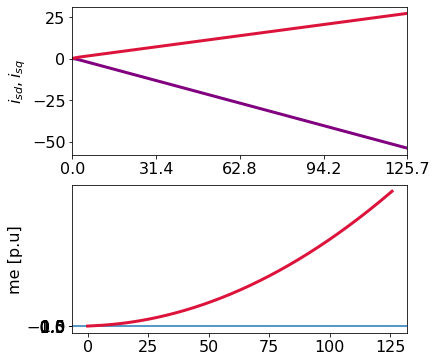

In [11]:
pl.figure(531, figsize = (6,6))
pl.rc('font', size = 16)
pl.subplot(2,1,1)
pl.plot(Tta,  isd, 'purple', lw = 3) 
pl.plot(Tta,isq ,'crimson' ,lw =3)
pl.xlim(0,tend)
pl.ylabel(r'$i_{sd}, i_{sq}$' )
pl.xticks(np.linspace(0,tend,5))
ax1 = pl.subplot(2,1,2)
ax1.axhline(0)
ax1.plot(Tta, me, 'crimson', lw =3)
ax1.set_yticks(np.linspace(-1.0,1.0,5))
ax1.set_ylabel('me [p.u]')
# t1w = np.pi*2*45
# t2w = np.pi*2*60
# pl.xlim(t1w,t2w)
# # pl.xlim(0,tend)
# pl.axhline(0.75)
# pl.axhline(-0.75)
# pl.ylabel(r'$i_{s\alpha}, \i_{s\beta}$' )
# pl.xticks(np.linspace(t1w,t2w,5))
# pl.yticks(np.linspace(-1.0,1.0,5))
# pl.ylim(-1.0,1.0)
# ax1 = pl.subplot(2,1,2)
# ax1.plot(Tta, isd, 'tomato', lw =3, label = r'$i_{sd}$')
# ax1.plot(t1w+1,0.26,'o', c = 'tomato')
# pl.text(t1w+2,0.28, 'i = {0:1.3f}'.format(isd[-1]), fontsize = 12)
# ax1.plot(Tta,isq, 'purple', lw =3, label = r'$i_{sq}$')
# ax1.plot(Tta,psird, 'magenta', lw=2)
# ax1.set_ylabel(r'$i_{sd}, \i_{sq}$' )
# ax1.set_xlabel(r'$\omega t$')
# ax2 = ax1.twinx()
# ax2.plot(Tta,FCangle, 'olive', lw =2)
# pl.rcParams['legend.fontsize']=12
# ax1.legend(loc = 'upper left')

#pl.axhline(1.0)
#pl.axhline(-1.0)

# t1w = np.pi*2*45
# t2w = np.pi*2*60
# ax1.set_xlim(t1w,t2w)
# ax1.set_xticks(np.linspace(t1w,t2w,5))
# ax1.set_yticks(np.linspace(0,1.0,6))
# ax1.set_ylim(-0.1,1.0)
# ax2.set_ylim(0,3.14)
# pl.savefig(dirfig + "FOCurrentsvst.pdf", bbox_inches = 'tight', transparent = True)

# pl.figure(533, figsize = (4,4))
# pl.rc('font', size = 16)
# pl.rcParams['axes.titlesize']=14
# pl.plot(isd,isq,'crimson', lw =2, label = 'Field currents')
# # pl.plot(psird, psirq, 'blue', lw =4 , label = "actual")
# # pl.axhline(0)
# pl.axvline(0)
# pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.text(psird[-1]-0.05,psirq[-1]+0.08, r'$\vec{\psi}_r$', fontsize=16 )
# pl.xlabel(r'$d}$')
# pl.ylabel(r'$q$')
# pl.xlim(-0.01,1.0)
# pl.ylim(-0.02,1.0)
# # pl.xticks(np.linspace(-1.0,1.0,5))
# # pl.axis('equal')
# pl.rcParams['legend.fontsize']=9
# # pl.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
# pl.title('Field Coordinates')
# pl.savefig(dirfig + "FOXYvectors.pdf", bbox_inches = 'tight', transparent = True)


# pl.figure(536, figsize = (4,4))
# pl.rc('font', size = 16)
# pl.rcParams['axes.titlesize']=14
# pl.plot(isd,isq,'crimson', lw =2, label = 'Field currents')
# # pl.plot(psird, psirq, 'blue', lw =4 , label = "actual")
# # pl.axhline(0)
# pl.axvline(0)
# pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)

# pl.xlabel(r'$d}$')
# pl.ylabel(r'$q$')
# # pl.xlim(0,1.0)
# # pl.ylim(-0.02,1.0)
# # pl.xticks(np.linspace(-1.0,1.0,5))
# pl.axis('equal')
# pl.rcParams['legend.fontsize']=9
# # pl.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
# pl.title('Field Coordinates')
# # pl.savefig(dirfig + "FOXYvectorsFull.pdf", bbox_inches = 'tight', transparent = True)
# pl.show()
# print(isd[-1], isq[-1])

## 2. System Dynamics with Control

In [12]:
#Setting up the simulaton for rotor model
# We will use for loop for simulation 
rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3

tend = 20*2*np.pi
tstart = 0.0
delta_t = 0.01
n = 100000
# n2 = int(100*2*np.pi/0.01)
ws = -0.5
mL = 0.0
Tta = np.arange(tstart, tend,delta_t)
# Tta = np.linspace(tstart, tend, n2)
#delta_t = Tta[1] - Tta[0]
usd = np.zeros(len(Tta))
usq = np.zeros(len(Tta))
sol1 = np.zeros((len(Tta),3))
# sol2 = np.zeros((len(Tta),2))
# FCangle = np.zeros(len(Tta))
# Field coordinate currents
cosdelta = np.zeros(len(Tta))
sindelta = np.zeros(len(Tta))
isd = np.zeros(len(Tta))
isq = np.zeros(len(Tta))
eid = np.zeros(len(Tta))
eiq = np.zeros(len(Tta))
w = np.zeros(len(Tta))

# psird = np.zeros(len(Tta))
# psirq = np.zeros(len(Tta))

# # Initializing reference values for isd and isq:
isdrefval = -0.1
isdref = np.zeros(len(Tta))
isqref = np.zeros(len(Tta))

isqref1 = 0.0
isqref2 = 0.8
isqref3 = -0.35
for ii in range(len(Tta)):
    isdref[ii] = 0.0
    if (Tta[ii]>=10*2*np.pi):
        isqref[ii] = isqref3
        isdref[ii] = -isdrefval
    elif(Tta[ii]>=1*2*np.pi):
        isqref[ii]=isqref2
        isdref[ii] = isdrefval
    else:
        isqref[ii]=isqref1

me = np.zeros(len(Tta))
x0 = [0,0, ws] # isd, isq, ws
y0 = [1.0,0]

kpd = ld*1
Tid = 25.0e1

kpq = lq*2
Tiq = 25.0e1

Kparamsd = [kpd,Tid]
Kparamsq = [kpq,Tiq]

for ii in range(len(Tta)):
    #Start controller after first step
    if ii>=0:
        eid[ii] = isdref[ii-1] - isd[ii-1]
        PIed = [eid[ii],eid[ii-1]]
        usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
        eiq[ii] = isqref[ii-1] - isq[ii-1]
        PIeq = [eiq[ii],eiq[ii-1]]
        usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)
#         usd[ii] = 0
#         usq[ii] =.0001
    if ws>=1.0:
        a = 1.0
    else: 
        a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
#     usa[ii] = usd[ii-1]*cosdelta[ii-1] - usq[ii-1]*sindelta[ii-1]
#     usb[ii] = usq[ii-1]*cosdelta[ii-1] + usd[ii-1]*sindelta[ii-1]

    params = [usd[ii], usq[ii],w[ii], ws]
    sol1a = odeint(IM_dynstep,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
    sol1[ii]= sol1a[-1]
#     display(sol1a[-1])
    x0 = sol1a[-1]
#     me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
#     paramsw = [me[ii],0.0,tmech]
#     sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
#     y0 = sol2a[-1]
#     sol2[ii] = sol2a[-1]
#     #Rotor angle using internal angle
#     FCangle[ii] = sol2[ii][1]
#     gamma[ii] = sol2[ii][1]
#     w[ii] = sol2[ii][0]
#     #using resolver output
# #     FCangle[ii] = sol2[ii]
#     cosdelta[ii] = np.cos(FCangle[ii])
#     sindelta[ii] = np.sin(FCangle[ii])
    #Coordinate transformation
    isd[ii] = sol1[ii][0]
    isq[ii] = sol1[ii][1]
#     #Convert stator coordinate current to field coordinates
#     isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
#     isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
    #Rotor flux in field coordinates Using estimator output as in practice
    #actual flux will not be available for measurement
#     psird[ii] = 1.0
#     psirq[ii]= 0.0

# for ii in range(len(Tta)):
#     if ws>=1.0:
#         a = 1.0
#     else: 
#         a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
# #     me[ii] = kr*(sol1[ii-1][2]*sol1[ii-1][1] - sol1[ii-1][3]*sol[ii-1][0]) - mL
#     params = [usa[ii], usb[ii],mL,ws]
#     sol1a = odeint(IM_dynstep,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#     sol1[ii]= sol1a[-1]
# #     display(sol1a[-1])
#     x0 = sol1a[-1]
# #     params2 = [sol1[ii][0], sol1[ii][1],sol1[ii][4]] # isa, isb, w
# #     sol2a = odeint(psirest_vr,y0,[0,delta_t], args = (params2,), atol = abserr, rtol= relerr)
# #     sol2[ii] = sol2a[-1]
# #     psircomp = np.complex(sol2[ii][0], sol2[ii][1])
# #     FCangle[ii] = np.arccos(sol2[ii][0]/np.abs(psircomp))
# #     cosdelta[ii] = sol2[ii][0]/np.abs(psircomp)
# #     sindelta[ii] = sol2[ii][1]/np.abs(psircomp)
# #     #Coordinate transformation 
# #     #Convert stator coordinate current to field coordinates
# #     isd[ii] = sol1[ii][0]*cosdelta[ii] + sol1[ii][1]*sindelta[ii]
# #     isq[ii] = sol1[ii][1]*cosdelta[ii] - sol1[ii][0]*sindelta[ii]
# #     #Rotor flux in field coordinates
# #     psird[ii] = sol2[ii][0]*cosdelta[ii] + sol2[ii][1]*sindelta[ii]
# #     psirq[ii] = sol2[ii][1]*cosdelta[ii] - sol2[ii][0]*sindelta[ii]
# #     y0 = sol2a[-1]
    
# isd = sol1[:, 0]
# isq = sol1[:, 1]
# w = sol1[:, 2]
# psra = sol1[:, 2]
# psrb = sol1[:, 3]
# w = sol1[:,4]
# psiradash = sol2[:,0]
# psirbdash = sol2[:,1]

#rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
me = psi_rm*isq + (l_d-l_q)*isd*isq

In [13]:
print(isd)
print(isq)
print(me)

[0.00100436 0.00097342 0.00089229 ... 0.10000011 0.10000011 0.10000011]
[-0.00058619  0.00581419  0.01203562 ... -0.34999994 -0.34999994
 -0.34999994]
[-0.00052742  0.00523128  0.01082922 ... -0.30576344 -0.30576344
 -0.30576344]


Text(0, 0.5, 'me [p.u]')

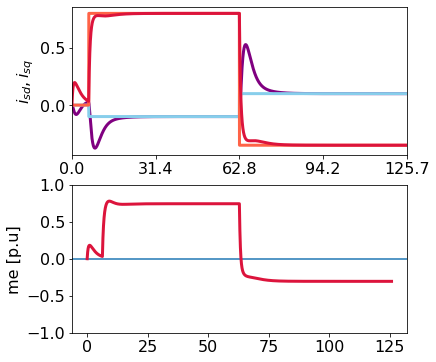

In [14]:
pl.figure(531, figsize = (6,6))
pl.rc('font', size = 16)
pl.subplot(2,1,1)
pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3) 
pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =3)
pl.xlim(0,tend)
pl.ylabel(r'$i_{sd}, i_{sq}$' )
pl.xticks(np.linspace(0,tend,5))
ax1 = pl.subplot(2,1,2)
ax1.axhline(0)
ax1.plot(Tta, me, 'crimson', lw =3)
ax1.set_yticks(np.linspace(-1.0,1.0,5))
ax1.set_ylabel('me [p.u]')
# t1w = np.pi*2*45
# t2w = np.pi*2*60
# pl.xlim(t1w,t2w)
# # pl.xlim(0,tend)
# pl.axhline(0.75)
# pl.axhline(-0.75)
# pl.ylabel(r'$i_{s\alpha}, \i_{s\beta}$' )
# pl.xticks(np.linspace(t1w,t2w,5))
# pl.yticks(np.linspace(-1.0,1.0,5))
# pl.ylim(-1.0,1.0)
# ax1 = pl.subplot(2,1,2)
# ax1.plot(Tta, isd, 'tomato', lw =3, label = r'$i_{sd}$')
# ax1.plot(t1w+1,0.26,'o', c = 'tomato')
# pl.text(t1w+2,0.28, 'i = {0:1.3f}'.format(isd[-1]), fontsize = 12)
# ax1.plot(Tta,isq, 'purple', lw =3, label = r'$i_{sq}$')
# ax1.plot(Tta,psird, 'magenta', lw=2)
# ax1.set_ylabel(r'$i_{sd}, \i_{sq}$' )
# ax1.set_xlabel(r'$\omega t$')
# ax2 = ax1.twinx()
# ax2.plot(Tta,FCangle, 'olive', lw =2)
# pl.rcParams['legend.fontsize']=12
# ax1.legend(loc = 'upper left')

#pl.axhline(1.0)
#pl.axhline(-1.0)

# t1w = np.pi*2*45
# t2w = np.pi*2*60
# ax1.set_xlim(t1w,t2w)
# ax1.set_xticks(np.linspace(t1w,t2w,5))
# ax1.set_yticks(np.linspace(0,1.0,6))
# ax1.set_ylim(-0.1,1.0)
# ax2.set_ylim(0,3.14)
# pl.savefig(dirfig + "FOCurrentsvst.pdf", bbox_inches = 'tight', transparent = True)

# pl.figure(533, figsize = (4,4))
# pl.rc('font', size = 16)
# pl.rcParams['axes.titlesize']=14
# pl.plot(isd,isq,'crimson', lw =2, label = 'Field currents')
# # pl.plot(psird, psirq, 'blue', lw =4 , label = "actual")
# # pl.axhline(0)
# pl.axvline(0)
# pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.text(psird[-1]-0.05,psirq[-1]+0.08, r'$\vec{\psi}_r$', fontsize=16 )
# pl.xlabel(r'$d}$')
# pl.ylabel(r'$q$')
# pl.xlim(-0.01,1.0)
# pl.ylim(-0.02,1.0)
# # pl.xticks(np.linspace(-1.0,1.0,5))
# # pl.axis('equal')
# pl.rcParams['legend.fontsize']=9
# # pl.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
# pl.title('Field Coordinates')
# pl.savefig(dirfig + "FOXYvectors.pdf", bbox_inches = 'tight', transparent = True)


# pl.figure(536, figsize = (4,4))
# pl.rc('font', size = 16)
# pl.rcParams['axes.titlesize']=14
# pl.plot(isd,isq,'crimson', lw =2, label = 'Field currents')
# # pl.plot(psird, psirq, 'blue', lw =4 , label = "actual")
# # pl.axhline(0)
# pl.axvline(0)
# pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)

# pl.xlabel(r'$d}$')
# pl.ylabel(r'$q$')
# # pl.xlim(0,1.0)
# # pl.ylim(-0.02,1.0)
# # pl.xticks(np.linspace(-1.0,1.0,5))
# pl.axis('equal')
# pl.rcParams['legend.fontsize']=9
# # pl.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
# pl.title('Field Coordinates')
# # pl.savefig(dirfig + "FOXYvectorsFull.pdf", bbox_inches = 'tight', transparent = True)
# pl.show()
# print(isd[-1], isq[-1])

## 3. System with Increasing Speed $\omega_s$

In [15]:
#Induction machine 5x5 dynamic model 

def PMSM_dynStep2By2(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_PMSMStep2By2(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1+ B[1][0]*(-w_s*psi_rm+u2))
#     dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)

    return [dx0_dt,dx1_dt]


def mach_PMSMStep2By2(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
#     a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
#     a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
#     a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
#     b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
#     c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0
    A = ([a11,a12],[a21,a22],[a31,a32])
    B = ([b11], [b21])
    C = ([c11, c22])
    D= ([0,0],[0,0])
#     A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
#     B = ([b11], [b21], [b31])
#     C = ([c11, c22, c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [16]:
# def simulateSpeedingUpWithAcceleration(a):
#     #Setting up the simulaton for rotor model
#     # We will use for loop for simulation 
#     rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
#     tend = 20*2*np.pi
#     tstart = 0.0
#     delta_t = 0.01
#     Tta = np.arange(tstart, tend,delta_t)
#     # ODE solver parameters
#     abserr = 1.0e-8
#     relerr = 1.0e-3
    
#     n = 100000
# #     n2 = int(100*2*np.pi/0.01)
#     # ws = -0.5
#     ws = np.zeros(len(Tta))
#     # Initializing ws:
# #     a = 0.0001 # angular acceleration
#     for i in range(1, len(Tta)):
#         new_ws = ws[i-1]+a
#         if(new_ws > 1):
#             ws[i] = 1
#         else:
#             ws[i] = new_ws
#     mL = 0.0
#     # Tta = np.linspace(tstart, tend, n2)
#     #delta_t = Tta[1] - Tta[0]
#     usd = np.zeros(len(Tta))
#     usq = np.zeros(len(Tta))
#     sol1 = np.zeros((len(Tta),2))
#     # sol2 = np.zeros((len(Tta),2))
#     # FCangle = np.zeros(len(Tta))
#     # Field coordinate currents
#     cosdelta = np.zeros(len(Tta))
#     sindelta = np.zeros(len(Tta))
#     isd = np.zeros(len(Tta))
#     isq = np.zeros(len(Tta))
#     eid = np.zeros(len(Tta))
#     eiq = np.zeros(len(Tta))
#     w = np.zeros(len(Tta))

#     # psird = np.zeros(len(Tta))
#     # psirq = np.zeros(len(Tta))

#     # # Initializing reference values for isd and isq:
#     isdrefval = -0.1
#     isdref = np.zeros(len(Tta))
#     isqref = np.zeros(len(Tta))

#     isqref1 = 0.0
#     isqref2 = 0.8
#     isqref3 = -0.35
#     for ii in range(len(Tta)):
#         isdref[ii] = 0.0
#         if (Tta[ii]>=10*2*np.pi):
#             isqref[ii] = isqref3
#             isdref[ii] = -isdrefval
#         elif(Tta[ii]>=1*2*np.pi):
#             isqref[ii]=isqref2
#             isdref[ii] = isdrefval
#         else:
#             isqref[ii]=isqref1

#     me = np.zeros(len(Tta))
#     x0 = [0,0] # isd, isq, ws
#     y0 = [1.0,0]

#     kpd = ld*1
#     Tid = 25.0e1

#     kpq = lq*2
#     Tiq = 25.0e1

#     Kparamsd = [kpd,Tid]
#     Kparamsq = [kpq,Tiq]

#     for ii in range(len(Tta)):
#         #Start controller after first step
#         if ii>=0:
#             eid[ii] = isdref[ii-1] - isd[ii-1]
#             PIed = [eid[ii],eid[ii-1]]
#             usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#             eiq[ii] = isqref[ii-1] - isq[ii-1]
#             PIeq = [eiq[ii],eiq[ii-1]]
#             usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

#         # solve for the state variables: isd, isq
#         params = [usd[ii], usq[ii],w[ii], ws[ii]]
#         sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#         sol1[ii]= sol1a[-1]
#         x0 = sol1a[-1]
#         isd[ii] = sol1[ii][0]
#         isq[ii] = sol1[ii][1]


#     #rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
#     rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
#     return Tta, ws, me, isd, isq

In [17]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]

In [18]:
# def simulateSpeedingUpWithAcceleration(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3):
#     #Setting up the simulaton for rotor model
#     # We will use for loop for simulation 
#     rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
#     tend = 20*2*np.pi
#     tstart = 0.0
#     delta_t = 0.01
#     Tta = np.arange(tstart, tend,delta_t)
#     # ODE solver parameters
#     abserr = 1.0e-8
#     relerr = 1.0e-3
    
#     n = 100000
# #     n2 = int(100*2*np.pi/0.01)
#     # ws = -0.5
#     ws = -0.5
#     # Initializing ws:
# #     a = 0.0001 # angular acceleration
# #     for i in range(1, len(Tta)):
# #         new_ws = ws[i-1]+a
# #         if(new_ws > 1):
# #             ws[i] = 1
# #         else:
# #             ws[i] = new_ws
#     mL = 0.0
#     # Tta = np.linspace(tstart, tend, n2)
#     #delta_t = Tta[1] - Tta[0]
#     usd = np.zeros(len(Tta))
#     usq = np.zeros(len(Tta))
#     sol1 = np.zeros((len(Tta),2))
#     sol2 = np.zeros((len(Tta),2))
#     FCangle = np.zeros(len(Tta))
#     gamma = np.zeros(len(Tta)) # rotor angle
#     # Field coordinate currents
#     cosdelta = np.zeros(len(Tta))
#     sindelta = np.zeros(len(Tta))
#     isd = np.zeros(len(Tta))
#     isq = np.zeros(len(Tta))
#     eid = np.zeros(len(Tta))
#     eiq = np.zeros(len(Tta))
#     w = np.zeros(len(Tta))

#     # psird = np.zeros(len(Tta))
#     # psirq = np.zeros(len(Tta))

#     # # Initializing reference values for isd and isq:
#     isdrefval = -0.1
#     isdref = np.zeros(len(Tta))
#     isqref = np.zeros(len(Tta))

# #     isqref1 = 0.0
# #     isqref2 = 0.8
# #     isqref3 = -0.35
#     print("---")
#     print(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
#     print("---")
#     for ii in range(0, len(Tta)):
#         print(Tta[ii])
#         if(Tta[ii] >= 0 and Tta[ii] <= 2*np.pi):
#             isdref[ii] = 0.0
#             isqref[ii] = 0.0
#         elif (Tta[ii] >= 2*np.pi and Tta[ii] <= 10*np.pi):
#             isdref[ii] = float(isdRef1)
#             isqref[ii] = float(isqRef1)
#         elif(Tta[ii] >= 10*np.pi and Tta[ii] <= 30*np.pi):
#             isdref[ii] = float(isdRef2)
#             isqref[ii] = float(isqRef2)
#         else:
#             print(isdRef3)
#             isdref[ii] = float(isdRef3)
#             print(isdref[ii])
#             isqref[ii] = float(isqRef3)
#         print("-v-")
#         print(isdRef3)
#         print(float(isdRef3))
#         print("-^-")
#         print(isqRef2)
#         print(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
# #         print(isdref[ii])
# #         print(isqref[ii])

#     me = np.zeros(len(Tta))
#     x0 = [0,0] # isd, isq, ws
#     y0 = [0,0] # w, angle

#     kpd = ld*1
#     Tid = 25.0e1

#     kpq = lq*2
#     Tiq = 25.0e1

#     Kparamsd = [kpd,Tid]
#     Kparamsq = [kpq,Tiq]

#     for ii in range(0, len(Tta)):      
#         #Start controller after first step
#         if ii>=0:
#             eid[ii] = isdref[ii-1] - isd[ii-1]
#             PIed = [eid[ii],eid[ii-1]]
#             usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#             eiq[ii] = isqref[ii-1] - isq[ii-1]
#             PIeq = [eiq[ii],eiq[ii-1]]
#             usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

#         # solve for the state variables: isd, isq
#         params = [usd[ii], usq[ii],w[ii], ws]
#         sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#         sol1[ii]= sol1a[-1]
#         x0 = sol1a[-1]
#         isd[ii] = sol1[ii][0]
#         isq[ii] = sol1[ii][1]
#         # solve for w:
#         me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
#         paramsw = [me[ii],0.0,tmech]
#         sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
#         y0 = sol2a[-1]
#         sol2[ii] = sol2a[-1]
#         FCangle[ii] = sol2[ii][1]
#         gamma[ii] = sol2[ii][1]
#         w[ii] = sol2[ii][0]
#         #Convert field coordinate stator to field coordinates
# #         isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
# #         isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
#     #rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
#     rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
# #     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
#     return Tta, w, me, isd, isq, isdref, isqref

In [19]:
# def calculateIsdIsqRefsBySpeed(w, isqOrig):
#     aAbs = 0.045 # angular acceleration
#     if(w > 0):
#         a = aAbs
#     else:
#         a = -aAbs
#     rs,ld,lq, tmech, psirm = mach_para(mach_mc)
#     isq = isqOrig
#     while((psi_rm+(ld-lq)*isq) == 0 and abs(isd) > 1 and isq >= -1 and isq <= 1):
#         isq -= 0.001
#     if((psi_rm+(ld-lq)*isq) != 0):
#         isd = tmech*(a+ml)/(psi_rm+(ld-lq)*isq)
#     else:
#         isq = isqOrig
#         while((psi_rm+(ld-lq)*isq) == 0 and abs(isd) > 1 and isq >= -1 and isq <= 1):
#             isq += 0.001
#         if((psi_rm+(ld-lq)*isq) != 0):
#             isd = tmech*(a+ml)/(psi_rm+(ld-lq)*isq)
#     if((psi_rm+(ld-lq)*isq) == 0 or abs(isd)>1 or abs(isq)>1):
#         isd, isq = 1, -0.35 # No solotion
#     print("return isd, isq:")
#     print(isd, isq)
#     return isd, isq

In [20]:
# def calculateIsdIsqRefsBySpeed(w, isdOrig):
#     aAbs = 0.005 # angular acceleration
#     if(w > 0):
#         a = aAbs
#     else:
#         a = -aAbs
#     rs,ld,lq, tmech, psirm = mach_para(mach_mc)
#     isd = isdOrig
#     while((psi_rm+(ld-lq)*isd) == 0 and abs(isq) > 1 and isd >= -1 and isd <= 1):
#         isd -= 0.001
#     if((psi_rm+(ld-lq)*isd) != 0):
#         isq = (tmech*a+ml)/(psi_rm+(ld-lq)*isd)
#     else:
#         isd = isdOrig
#         while((psi_rm+(ld-lq)*isd) == 0 and abs(isq) > 1 and isd >= -1 and isd <= 1):
#             isd += 0.001
#         if((psi_rm+(ld-lq)*isq) != 0):
#             isq = (tmech*a+ml)/(psi_rm+(ld-lq)*isd)
#     if((psi_rm+(ld-lq)*isq) == 0):
#         isd, isq = 1, -0.35 # No solotion
#     print("return isd, isq:")
#     print(isd, isq)
#     return isd, isq

In [21]:
# def simulateSpeedingUpWithAcceleration(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3):
#     #Setting up the simulaton for rotor model
#     # We will use for loop for simulation 
#     rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
#     tend = 20*2*np.pi
#     tstart = 0.0
#     delta_t = 0.01
#     Tta = np.arange(tstart, tend,delta_t)
#     # ODE solver parameters
#     abserr = 1.0e-8
#     relerr = 1.0e-3
    
#     n = 100000
# #     n2 = int(100*2*np.pi/0.01)
#     # ws = -0.5
#     ws = -0.5
#     # Initializing ws:
# #     a = 0.0001 # angular acceleration
# #     for i in range(1, len(Tta)):
# #         new_ws = ws[i-1]+a
# #         if(new_ws > 1):
# #             ws[i] = 1
# #         else:
# #             ws[i] = new_ws
#     mL = 0.0
#     # Tta = np.linspace(tstart, tend, n2)
#     #delta_t = Tta[1] - Tta[0]
#     usd = np.zeros(len(Tta))
#     usq = np.zeros(len(Tta))
#     sol1 = np.zeros((len(Tta),2))
#     sol2 = np.zeros((len(Tta),2))
#     FCangle = np.zeros(len(Tta))
#     gamma = np.zeros(len(Tta)) # rotor angle
#     # Field coordinate currents
#     cosdelta = np.zeros(len(Tta))
#     sindelta = np.zeros(len(Tta))
#     isd = np.zeros(len(Tta))
#     isq = np.zeros(len(Tta))
#     eid = np.zeros(len(Tta))
#     eiq = np.zeros(len(Tta))
#     w = np.zeros(len(Tta))

#     me = np.zeros(len(Tta))
#     x0 = [0,0] # isd, isq, ws
#     y0 = [0,0] # w, angle

#     kpd = ld*1
#     Tid = 25.0e1

#     kpq = lq*2
#     Tiq = 25.0e1

#     Kparamsd = [kpd,Tid]
#     Kparamsq = [kpq,Tiq]
#     flag = 0

# #     for ii in range(0, len(Tta))
#     ii =0
#     isdref = 0.0
#     isqref = 0.0
#     isdrefs = [isdref]
#     isqrefs = [isqref]
#     endOfStablization = 0
#     while(ii < len(Tta)):      
#         #Start controller after first step
#         if ii>=0:
#             eid[ii] = isdref - isd[ii-1]
#             PIed = [eid[ii],eid[ii-1]]
#             usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#             eiq[ii] = isqref - isq[ii-1]
#             PIeq = [eiq[ii],eiq[ii-1]]
#             usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

#         # solve for the state variables: isd, isq
#         params = [usd[ii], usq[ii],w[ii], ws]
#         sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#         sol1[ii]= sol1a[-1]
#         x0 = sol1a[-1]
#         isd[ii] = sol1[ii][0]
#         isq[ii] = sol1[ii][1]
#         # solve for w:
#         me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
#         paramsw = [me[ii],0.0,tmech]
#         sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
#         y0 = sol2a[-1]
#         sol2[ii] = sol2a[-1]
#         FCangle[ii] = sol2[ii][1]
#         gamma[ii] = sol2[ii][1]
#         w[ii] = sol2[ii][0]
# #         TtaEnd = Tta[ii]
#         print("w[ii]:")
#         print(ii, Tta[ii], w[ii])
#         while(flag == 0 and ii+1 < len(Tta) and abs(w[ii]) > 0.001):
#             print("stablize the speed")
#             ii+=1
#             #Start controller after first step
#             if ii>=0:
#                 eid[ii] = isdref - isd[ii-1]
#                 PIed = [eid[ii],eid[ii-1]]
#                 usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#                 eiq[ii] = isqref - isq[ii-1]
#                 PIeq = [eiq[ii],eiq[ii-1]]
#                 usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)
#             # solve for the state variables: isd, isq
#             params = [usd[ii], usq[ii],w[ii], ws]
#             sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#             sol1[ii]= sol1a[-1]
#             x0 = sol1a[-1]
#             isd[ii] = sol1[ii][0]
#             isq[ii] = sol1[ii][1]
#             # solve for w:
#             me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
#             paramsw = [me[ii],0.0,tmech]
#             sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
#             y0 = sol2a[-1]
#             sol2[ii] = sol2a[-1]
#             FCangle[ii] = sol2[ii][1]
#             gamma[ii] = sol2[ii][1]
#             w[ii] = sol2[ii][0]
#             TtaEnd = Tta[ii]
            
#             print("w[ii]:")
#             print(ii, Tta[ii],w[ii])
#             # update isd isq:
            
#             isdref = 1
#             isqref = -0.35
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
#             if(abs(w[ii]) > 0.001):
#                 flag = 1
#                 break
#             endOfStablization = ii
#         ii += 1
#         # update isd isq
#         if(ii < len(Tta) and ii >= endOfStablization and ii < endOfStablization*2):
#             print("Uniform speed")
#             isdref = 0
#             isqref = 0
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
#         elif(ii < len(Tta)):
#             print("accelerating")
#             isdref = 1.0
#             isqref = -0.35
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
# #         elif(ii < len(Tta)):
# #             print("accelerating")
# #             isdref, isqref = calculateIsdIsqRefsBySpeed(w[ii], 0.5)
# #             isdrefs.append(isdref)
# #             isqrefs.append(isqref)
# #         if(ii < len(Tta)):
# #             isdref = 0
# #             isqref = 0
# #             isdrefs.append(isdref)
# #             isqrefs.append(isqref)
        
#         #Convert field coordinate stator to field coordinates
# #         isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
# #         isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
#     #rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
# #     TtaReturn = Tta[0: int(TtaEnd)]
#     rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
# #     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
#     return Tta, w, me, isd, isq, np.array(isdrefs), np.array(isqrefs)

In [22]:
# # a = 0.045
# ml, a, isq = 0.0, 0.045, -0.35
# isdRef1, isqRef1 = calculateIsdIsqRefs(ml, a, isq)
# print(isdRef1, isqRef1)
# isdRef2, isqRef2 = calculateIsdIsqRefs(ml, 0.0, isqRef1)
# print(isdRef2, isqRef2)
# isdRef3, isqRef3 = calculateIsdIsqRefs(ml, -a, isqRef2)
# print(isdRef3, isqRef3)
# # isdRef = np.array([isdRef1, isdRef2, isdRef3])
# # isqRef = np.array([isqRef1, isqRef2, isqRef3])
# print(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
# # Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
# Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration(isdRef1, 0, isdRef3, isqRef1, 0, isqRef3)

# # print(w)
# plotDynamicForSpeedingUp(Tta, w, me, isd, isq, isdref, isqref)

In [23]:
zeroThresh = 0.0005
def calculateIsdIsqRefsBySpeedSimple(w, isSlowingDown):
    isd, isq = 0.0, 0.0
    a = 0.002
    ml = 0.0
    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 0):
            isd = 0.2
            isq = 0.105
        else:
            isd = 0.5
            isq = -0.09
    else:
        # a < 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 0):
            isd = 0.5
            isq = -0.09
        else:
            isd = 0.2
            isq = 0.105
#     else:
#         isd, isq = 0.0, 0.0
#     if isSlowingDown < 0:
#         # slowing down:
#         isd = 0.5
#         isq = -0.09
#     else:
#         # speeding up
#         isd = 0.2
#         isq = 0.105
    print("calculate isd, isq:")
    print(isd, isq)
    return isd, isq
        

In [24]:
def braking(w, isSlowingDown):
    print("in braking")
    print(w)
    isd, isq = 0.0, 0.0
    a = 0.002
    ml = 0.0
    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 0):
            isd = 0.2
            isq = 0.105
        else:
            isd = 0.5
            isq = -0.09
    else:
        # a < 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 0):
            isd = 0.5
            isq = -0.09
        else:
            isd = 0.2
            isq = 0.105
        
#     if isSlowingDown < 0:
#         # slowing down:
#         isd = 0.5
#         isq = -0.09
#     else:
#         # speeding up
#         isd = 0.2
#         isq = 0.105
    print("calculate isd, isq:")
    print(isd, isq)
    return isd, isq
#     isd, isq = 0.0, 0.0
#     if(abs(w) <= zeroThresh):
#         isd, isq = 0.0, 0.0
#     else:
#         isd, isq = calculateIsdIsqRefsBySpeedSimple(w, 1)
#     print("braking: isd, isq:")
#     print(isd, isq)
    return isd, isq

In [40]:
def simulateSpeedingUpWithAcceleration():
    #Setting up the simulaton for rotor model
    # We will use for loop for simulation 
    rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
    tend = 20*2.5*np.pi
    tstart = 0.0
    delta_t = 0.01
    Tta = np.arange(tstart, tend,delta_t)
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-3
    
    n = 100000
#     n2 = int(100*2*np.pi/0.01)
    # ws = -0.5
    ws = -0.5
    # Initializing ws:
#     a = 0.0001 # angular acceleration
#     for i in range(1, len(Tta)):
#         new_ws = ws[i-1]+a
#         if(new_ws > 1):
#             ws[i] = 1
#         else:
#             ws[i] = new_ws
    mL = 0.0
    # Tta = np.linspace(tstart, tend, n2)
    #delta_t = Tta[1] - Tta[0]
    usd = np.zeros(len(Tta))
    usq = np.zeros(len(Tta))
    sol1 = np.zeros((len(Tta),2))
    sol2 = np.zeros((len(Tta),2))
    FCangle = np.zeros(len(Tta))
    gamma = np.zeros(len(Tta)) # rotor angle
    # Field coordinate currents
    cosdelta = np.zeros(len(Tta))
    sindelta = np.zeros(len(Tta))
    isd = np.zeros(len(Tta))
    isq = np.zeros(len(Tta))
    eid = np.zeros(len(Tta))
    eiq = np.zeros(len(Tta))
    w = np.zeros(len(Tta))

    me = np.zeros(len(Tta))
    x0 = [0,0] # isd, isq, ws
    y0 = [0,0] # w, angle

    kpd = ld*1
    Tid = 25.0e1

    kpq = lq*2
    Tiq = 25.0e1

    Kparamsd = [kpd,Tid]
    Kparamsq = [kpq,Tiq]
    flag = 0

#     for ii in range(0, len(Tta))
    ii =0
    isdref = 0.0
    isqref = 0.0
    isdrefs = [isdref]
    isqrefs = [isqref]
    endOfStablization = 0
    while(ii < len(Tta)):      
        #Start controller after first step
        if ii>=0:
            eid[ii] = isdref - isd[ii-1]
            PIed = [eid[ii],eid[ii-1]]
            usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
            eiq[ii] = isqref - isq[ii-1]
            PIeq = [eiq[ii],eiq[ii-1]]
            usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

        # solve for the state variables: isd, isq
        params = [usd[ii], usq[ii],w[ii], ws]
        sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
        sol1[ii]= sol1a[-1]
        x0 = sol1a[-1]
        isd[ii] = sol1[ii][0]
        isq[ii] = sol1[ii][1]
        # solve for w:
        me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
        paramsw = [me[ii],0.0,tmech]
        sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
        y0 = sol2a[-1]
        sol2[ii] = sol2a[-1]
        FCangle[ii] = sol2[ii][1]
        gamma[ii] = sol2[ii][1]
        w[ii] = sol2[ii][0]
#         TtaEnd = Tta[ii]
        print("w[ii]:")
        print(ii, Tta[ii], w[ii])
        while(flag == 0 and ii+1 < len(Tta) and abs(w[ii]) > zeroThresh):
            print("stablize the speed")
            ii+=1
            #Start controller after first step
            if ii>=0:
                eid[ii] = isdref - isd[ii-1]
                PIed = [eid[ii],eid[ii-1]]
                usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
                eiq[ii] = isqref - isq[ii-1]
                PIeq = [eiq[ii],eiq[ii-1]]
                usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)
            # solve for the state variables: isd, isq
            params = [usd[ii], usq[ii],w[ii], ws]
            sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
            sol1[ii]= sol1a[-1]
            x0 = sol1a[-1]
            isd[ii] = sol1[ii][0]
            isq[ii] = sol1[ii][1]
            # solve for w:
            me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
            paramsw = [me[ii],0.0,tmech]
            sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
            y0 = sol2a[-1]
            sol2[ii] = sol2a[-1]
            FCangle[ii] = sol2[ii][1]
            gamma[ii] = sol2[ii][1]
            w[ii] = sol2[ii][0]
            TtaEnd = Tta[ii]
            
            print("w[ii]:")
            print(ii, Tta[ii],w[ii])
            # update isd isq:
            
            isdref = 1
            isqref = -0.35
            isdrefs.append(isdref)
            isqrefs.append(isqref)
            if(Tta[ii] > 10*np.pi ):
                flag = 1
                break
#             if(w[ii] == 0 ):
#                 flag = 1
#                 break
            endOfStablization = ii
#         ii += 1
        # update isd isq
#         if(ii < len(Tta) and ii >= endOfStablization and ii < endOfStablization*2):
#             print("Uniform speed from:")
#             print(Tta[ii])
#             isdref = 0
#             isqref = 0
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
# #         elif(ii < len(Tta)):
# #             print("Accelerating from:")
# #             print(Tta[ii])
# #             isdref = -0.5
# #             isqref = 0
# #             isdrefs.append(isdref)
# #             isqrefs.append(isqref)
#         elif(ii < len(Tta) and ii < endOfStablization*3):
#             print("Speeding up from:")
#             print(Tta[ii])
#             isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 0)
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
        if(ii < len(Tta) and ii >= endOfStablization and ii < endOfStablization*2):
            print("Speeding up from:")
            print(Tta[ii])
            isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 0)
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        elif(ii < len(Tta) and ii < endOfStablization*4):
            print("Uniform speed from:")
            print(Tta[ii])
            isdref = 0
            isqref = 0
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        elif(ii < len(Tta)):
            print("Before Braking: w:")
            print(w[ii])
            print(Tta[ii])
            isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 1)
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        ii += 1
#         elif(ii < len(Tta)):
#             print("Braking:")
#             print(Tta[ii])
#             print("before braking: w[ii]")
#             print(w[ii])
#             isdref, isqref = braking(w[ii])
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
#         elif(ii < len(Tta)):
#             print("Speeding up from:")
#             print(Tta[ii])
#             isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 0)
#             if(w[ii] > 0):
#                 isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 1)
#             elif(w[ii] < 0)
#                 isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 1)
        
#         if(ii < len(Tta)):
#             isdref = 0
#             isqref = 0
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
        
        #Convert field coordinate stator to field coordinates
#         isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
#         isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
    #rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
#     TtaReturn = Tta[0: int(TtaEnd)]
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
    return Tta, w, me, isd, isq, np.array(isdrefs)[0:len(Tta)], np.array(isqrefs)[0:len(Tta)]

In [41]:
# import matplotlib.pyplot as pl
# %matplotlib inline
def plotDynamicForSpeedingUp(Tta, w1, me1, isd1, isq1, isdref, isqref):
    pl.figure(531, figsize = (6,6))
    pl.rc('font', size = 16)
    # plot the isd and isq
    pl.subplot(2,1,1)
    pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3)
    pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =2)
#     pl.plot(Tta,  isdref,'skyblue', lw=3)
#     pl.plot(Tta, isqref ,'crimson' ,lw =3)
    pl.xlim(0,tend)
    pl.ylabel(r'$isd, isq$' )
    pl.xticks(np.linspace(0,tend,5))
    # # plot isd and isq:
    # pl.subplot(2,1,2)
    # pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3) 
    # pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =3)
    # pl.xlim(0,tend)
    # pl.ylabel(r'$i_{sd}, i_{sq}$' )
    # pl.xticks(np.linspace(0,tend,5))
    # plot me
    # plot torque and speed:
    ax1 = pl.subplot(2,1,2)
    ax1.axhline(0)
    ax1.plot(Tta, me1, 'crimson', lw =2)
    ax1.set_yticks(np.linspace(-1.0,1.0,5))
    ax1.set_ylabel('me [p.u]')
    ax2 = ax1.twinx()
    ax2.set_ylabel('$\omega$')
    ax2.plot(Tta,w, 'peru', lw =3)

w[ii]:
0 0.0 1.2831457301089506e-06
Before Braking: w:
1.2831457301089506e-06
0.0
calculate isd, isq:
0.2 0.105
w[ii]:
1 0.01 4.231255180455482e-06
Before Braking: w:
4.231255180455482e-06
0.01
calculate isd, isq:
0.2 0.105
w[ii]:
2 0.02 8.796254366217043e-06
Before Braking: w:
8.796254366217043e-06
0.02
calculate isd, isq:
0.2 0.105
w[ii]:
3 0.03 1.4931442030414804e-05
Before Braking: w:
1.4931442030414804e-05
0.03
calculate isd, isq:
0.2 0.105
w[ii]:
4 0.04 2.2591474269055643e-05
Before Braking: w:
2.2591474269055643e-05
0.04
calculate isd, isq:
0.2 0.105
w[ii]:
5 0.05 3.173232123738134e-05
Before Braking: w:
3.173232123738134e-05
0.05
calculate isd, isq:
0.2 0.105
w[ii]:
6 0.06 4.231122506239684e-05
Before Braking: w:
4.231122506239684e-05
0.06
calculate isd, isq:
0.2 0.105
w[ii]:
7 0.07 5.4286659151196476e-05
Before Braking: w:
5.4286659151196476e-05
0.07
calculate isd, isq:
0.2 0.105
w[ii]:
8 0.08 6.761828887480014e-05
Before Braking: w:
6.761828887480014e-05
0.08
calculate isd, i

w[ii]:
356 3.56 0.0005568703284333848
stablize the speed
w[ii]:
357 3.5700000000000003 0.0005684361259073616
stablize the speed
w[ii]:
358 3.58 0.0005787593500748154
stablize the speed
w[ii]:
359 3.59 0.0005878672395146587
stablize the speed
w[ii]:
360 3.6 0.0005957863716328582
stablize the speed
w[ii]:
361 3.61 0.0006025426794872839
stablize the speed
w[ii]:
362 3.62 0.0006081614682095767
stablize the speed
w[ii]:
363 3.63 0.0006126674310381369
stablize the speed
w[ii]:
364 3.64 0.0006160846649811407
stablize the speed
w[ii]:
365 3.65 0.0006184366861386705
stablize the speed
w[ii]:
366 3.66 0.0006197464447377376
stablize the speed
w[ii]:
367 3.67 0.000620036340041719
stablize the speed
w[ii]:
368 3.68 0.0006193282381554976
stablize the speed
w[ii]:
369 3.69 0.0006176434621703966
stablize the speed
w[ii]:
370 3.7 0.000615002824588552
stablize the speed
w[ii]:
371 3.71 0.0006114266431112819
stablize the speed
w[ii]:
372 3.72 0.0006069347519639659
stablize the speed
w[ii]:
373 3.73 0.000

1015 10.15 -0.026297470322163844
stablize the speed
w[ii]:
1016 10.16 -0.02634880079277915
stablize the speed
w[ii]:
1017 10.17 -0.026400127123531347
stablize the speed
w[ii]:
1018 10.18 -0.026451449335714874
stablize the speed
w[ii]:
1019 10.19 -0.02650276745064832
stablize the speed
w[ii]:
1020 10.200000000000001 -0.02655408148967301
stablize the speed
w[ii]:
1021 10.21 -0.026605391474151606
stablize the speed
w[ii]:
1022 10.22 -0.02665669742546674
stablize the speed
w[ii]:
1023 10.23 -0.026707999365019643
stablize the speed
w[ii]:
1024 10.24 -0.026759297314228794
stablize the speed
w[ii]:
1025 10.25 -0.02681059129452861
stablize the speed
w[ii]:
1026 10.26 -0.026861881327368105
stablize the speed
w[ii]:
1027 10.27 -0.02691316743420959
stablize the speed
w[ii]:
1028 10.28 -0.02696444963652737
stablize the speed
w[ii]:
1029 10.290000000000001 -0.027015727955806514
stablize the speed
w[ii]:
1030 10.3 -0.027067002413541555
stablize the speed
w[ii]:
1031 10.31 -0.027118273031235218
stabl

w[ii]:
1571 15.71 -0.054650373617719836
stablize the speed
w[ii]:
1572 15.72 -0.05470147494939234
stablize the speed
w[ii]:
1573 15.73 -0.054752577178222586
stablize the speed
w[ii]:
1574 15.74 -0.05480368030349922
stablize the speed
w[ii]:
1575 15.75 -0.054854784324501346
stablize the speed
w[ii]:
1576 15.76 -0.05490588924049871
stablize the speed
w[ii]:
1577 15.77 -0.05495699505075168
stablize the speed
w[ii]:
1578 15.780000000000001 -0.05500810175451144
stablize the speed
w[ii]:
1579 15.790000000000001 -0.055059209351020016
stablize the speed
w[ii]:
1580 15.8 -0.05511031783951034
stablize the speed
w[ii]:
1581 15.81 -0.05516142721920642
stablize the speed
w[ii]:
1582 15.82 -0.05521253748932341
stablize the speed
w[ii]:
1583 15.83 -0.05526364864906763
stablize the speed
w[ii]:
1584 15.84 -0.055314760697636675
stablize the speed
w[ii]:
1585 15.85 -0.055365873634219596
stablize the speed
w[ii]:
1586 15.860000000000001 -0.05541698745799685
stablize the speed
w[ii]:
1587 15.8700000000000

w[ii]:
2326 23.26 -0.09340417985236724
stablize the speed
w[ii]:
2327 23.27 -0.09345564045981908
stablize the speed
w[ii]:
2328 23.28 -0.09350710123311576
stablize the speed
w[ii]:
2329 23.29 -0.09355856217183432
stablize the speed
w[ii]:
2330 23.3 -0.09361002327555287
stablize the speed
w[ii]:
2331 23.31 -0.09366148454385063
stablize the speed
w[ii]:
2332 23.32 -0.09371294597630793
stablize the speed
w[ii]:
2333 23.330000000000002 -0.09376440757250623
stablize the speed
w[ii]:
2334 23.34 -0.0938158693320281
stablize the speed
w[ii]:
2335 23.35 -0.09386733125445712
stablize the speed
w[ii]:
2336 23.36 -0.0939187933393781
stablize the speed
w[ii]:
2337 23.37 -0.09397025558637681
stablize the speed
w[ii]:
2338 23.38 -0.09402171799504021
stablize the speed
w[ii]:
2339 23.39 -0.09407318056495628
stablize the speed
w[ii]:
2340 23.400000000000002 -0.09412464329571414
stablize the speed
w[ii]:
2341 23.41 -0.09417610618690393
stablize the speed
w[ii]:
2342 23.42 -0.09422756923811694
stablize t

2686 26.86 -0.11193806477058987
stablize the speed
w[ii]:
2687 26.87 -0.11198956422502265
stablize the speed
w[ii]:
2688 26.88 -0.11204106374800869
stablize the speed
w[ii]:
2689 26.89 -0.11209256333943915
stablize the speed
w[ii]:
2690 26.900000000000002 -0.11214406299920432
stablize the speed
w[ii]:
2691 26.91 -0.11219556272719355
stablize the speed
w[ii]:
2692 26.92 -0.11224706252329533
stablize the speed
w[ii]:
2693 26.93 -0.1122985623873973
stablize the speed
w[ii]:
2694 26.94 -0.11235006231938625
stablize the speed
w[ii]:
2695 26.95 -0.11240156231914823
stablize the speed
w[ii]:
2696 26.96 -0.11245306238656844
stablize the speed
w[ii]:
2697 26.97 -0.11250456252153138
stablize the speed
w[ii]:
2698 26.98 -0.11255606272392077
stablize the speed
w[ii]:
2699 26.990000000000002 -0.11260756299361967
stablize the speed
w[ii]:
2700 27.0 -0.11265906333051037
stablize the speed
w[ii]:
2701 27.01 -0.11271056373447462
stablize the speed
w[ii]:
2702 27.02 -0.11276206420539338
stablize the spe

w[ii]:
3325 33.25 -0.13497839411702386
Speeding up from:
33.25
calculate isd, isq:
0.2 0.105
w[ii]:
3326 33.26 -0.134951734399443
Speeding up from:
33.26
calculate isd, isq:
0.2 0.105
w[ii]:
3327 33.27 -0.134924985102276
Speeding up from:
33.27
calculate isd, isq:
0.2 0.105
w[ii]:
3328 33.28 -0.1348981477789021
Speeding up from:
33.28
calculate isd, isq:
0.2 0.105
w[ii]:
3329 33.29 -0.1348712239669879
Speeding up from:
33.29
calculate isd, isq:
0.2 0.105
w[ii]:
3330 33.3 -0.13484421518863074
Speeding up from:
33.3
calculate isd, isq:
0.2 0.105
w[ii]:
3331 33.31 -0.13481712295050072
Speeding up from:
33.31
calculate isd, isq:
0.2 0.105
w[ii]:
3332 33.32 -0.13478994874398012
Speeding up from:
33.32
calculate isd, isq:
0.2 0.105
w[ii]:
3333 33.33 -0.1347626940453015
Speeding up from:
33.33
calculate isd, isq:
0.2 0.105
w[ii]:
3334 33.34 -0.1347353603156836
Speeding up from:
33.34
calculate isd, isq:
0.2 0.105
w[ii]:
3335 33.35 -0.1347079490014654
Speeding up from:
33.35
calculate isd, isq

3878 38.78 -0.12090536244570486
Speeding up from:
38.78
calculate isd, isq:
0.2 0.105
w[ii]:
3879 38.79 -0.12088494956770972
Speeding up from:
38.79
calculate isd, isq:
0.2 0.105
w[ii]:
3880 38.800000000000004 -0.12086454469982356
Speeding up from:
38.800000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
3881 38.81 -0.12084414778710317
Speeding up from:
38.81
calculate isd, isq:
0.2 0.105
w[ii]:
3882 38.82 -0.12082375877485732
Speeding up from:
38.82
calculate isd, isq:
0.2 0.105
w[ii]:
3883 38.83 -0.12080337760864632
Speeding up from:
38.83
calculate isd, isq:
0.2 0.105
w[ii]:
3884 38.84 -0.12078300423428161
Speeding up from:
38.84
calculate isd, isq:
0.2 0.105
w[ii]:
3885 38.85 -0.12076263859782543
Speeding up from:
38.85
calculate isd, isq:
0.2 0.105
w[ii]:
3886 38.86 -0.12074228064559034
Speeding up from:
38.86
calculate isd, isq:
0.2 0.105
w[ii]:
3887 38.87 -0.12072193032413882
Speeding up from:
38.87
calculate isd, isq:
0.2 0.105
w[ii]:
3888 38.88 -0.12070158758028278
Speeding up 

43.22
calculate isd, isq:
0.2 0.105
w[ii]:
4323 43.230000000000004 -0.11213052913655114
Speeding up from:
43.230000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4324 43.24 -0.11211093331559072
Speeding up from:
43.24
calculate isd, isq:
0.2 0.105
w[ii]:
4325 43.25 -0.11209133698133814
Speeding up from:
43.25
calculate isd, isq:
0.2 0.105
w[ii]:
4326 43.26 -0.11207174013251268
Speeding up from:
43.26
calculate isd, isq:
0.2 0.105
w[ii]:
4327 43.27 -0.11205214276785791
Speeding up from:
43.27
calculate isd, isq:
0.2 0.105
w[ii]:
4328 43.28 -0.11203254488614144
Speeding up from:
43.28
calculate isd, isq:
0.2 0.105
w[ii]:
4329 43.29 -0.11201294648615474
Speeding up from:
43.29
calculate isd, isq:
0.2 0.105
w[ii]:
4330 43.300000000000004 -0.111993347566713
Speeding up from:
43.300000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4331 43.31 -0.11197374812665484
Speeding up from:
43.31
calculate isd, isq:
0.2 0.105
w[ii]:
4332 43.32 -0.11195414816484213
Speeding up from:
43.32
calculate isd,

0.2 0.105
w[ii]:
4570 45.7 -0.10727410552746533
Speeding up from:
45.7
calculate isd, isq:
0.2 0.105
w[ii]:
4571 45.71 -0.107254381523601
Speeding up from:
45.71
calculate isd, isq:
0.2 0.105
w[ii]:
4572 45.72 -0.10723465708077497
Speeding up from:
45.72
calculate isd, isq:
0.2 0.105
w[ii]:
4573 45.730000000000004 -0.10721493219993625
Speeding up from:
45.730000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4574 45.74 -0.10719520688203445
Speeding up from:
45.74
calculate isd, isq:
0.2 0.105
w[ii]:
4575 45.75 -0.10717548112801968
Speeding up from:
45.75
calculate isd, isq:
0.2 0.105
w[ii]:
4576 45.76 -0.10715575493884247
Speeding up from:
45.76
calculate isd, isq:
0.2 0.105
w[ii]:
4577 45.77 -0.10713602831545378
Speeding up from:
45.77
calculate isd, isq:
0.2 0.105
w[ii]:
4578 45.78 -0.107116301258805
Speeding up from:
45.78
calculate isd, isq:
0.2 0.105
w[ii]:
4579 45.79 -0.1070965737698479
Speeding up from:
45.79
calculate isd, isq:
0.2 0.105
w[ii]:
4580 45.800000000000004 -0.1070768

calculate isd, isq:
0.2 0.105
w[ii]:
4827 48.27 -0.10219315893969952
Speeding up from:
48.27
calculate isd, isq:
0.2 0.105
w[ii]:
4828 48.28 -0.10217335144127962
Speeding up from:
48.28
calculate isd, isq:
0.2 0.105
w[ii]:
4829 48.29 -0.10215354371796151
Speeding up from:
48.29
calculate isd, isq:
0.2 0.105
w[ii]:
4830 48.300000000000004 -0.10213373577037758
Speeding up from:
48.300000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4831 48.31 -0.10211392759915852
Speeding up from:
48.31
calculate isd, isq:
0.2 0.105
w[ii]:
4832 48.32 -0.10209411920493339
Speeding up from:
48.32
calculate isd, isq:
0.2 0.105
w[ii]:
4833 48.33 -0.10207431058832948
Speeding up from:
48.33
calculate isd, isq:
0.2 0.105
w[ii]:
4834 48.34 -0.10205450174997249
Speeding up from:
48.34
calculate isd, isq:
0.2 0.105
w[ii]:
4835 48.35 -0.10203469269048637
Speeding up from:
48.35
calculate isd, isq:
0.2 0.105
w[ii]:
4836 48.36 -0.10201488341049343
Speeding up from:
48.36
calculate isd, isq:
0.2 0.105
w[ii]:
4837 48

5278 52.78 -0.09324433573070182
Speeding up from:
52.78
calculate isd, isq:
0.2 0.105
w[ii]:
5279 52.79 -0.09322447040023168
Speeding up from:
52.79
calculate isd, isq:
0.2 0.105
w[ii]:
5280 52.800000000000004 -0.09320460500418631
Speeding up from:
52.800000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
5281 52.81 -0.09318473954273512
Speeding up from:
52.81
calculate isd, isq:
0.2 0.105
w[ii]:
5282 52.82 -0.09316487401604698
Speeding up from:
52.82
calculate isd, isq:
0.2 0.105
w[ii]:
5283 52.83 -0.09314500842429031
Speeding up from:
52.83
calculate isd, isq:
0.2 0.105
w[ii]:
5284 52.84 -0.09312514276763309
Speeding up from:
52.84
calculate isd, isq:
0.2 0.105
w[ii]:
5285 52.85 -0.09310527704624277
Speeding up from:
52.85
calculate isd, isq:
0.2 0.105
w[ii]:
5286 52.86 -0.09308541126028638
Speeding up from:
52.86
calculate isd, isq:
0.2 0.105
w[ii]:
5287 52.870000000000005 -0.09306554540993046
Speeding up from:
52.870000000000005
calculate isd, isq:
0.2 0.105
w[ii]:
5288 52.88 -0.0930

0.2 0.105
w[ii]:
5803 58.03 -0.0828089810407974
Speeding up from:
58.03
calculate isd, isq:
0.2 0.105
w[ii]:
5804 58.04 -0.08278909667970422
Speeding up from:
58.04
calculate isd, isq:
0.2 0.105
w[ii]:
5805 58.050000000000004 -0.08276921229985562
Speeding up from:
58.050000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
5806 58.06 -0.08274932790129191
Speeding up from:
58.06
calculate isd, isq:
0.2 0.105
w[ii]:
5807 58.07 -0.08272944348405341
Speeding up from:
58.07
calculate isd, isq:
0.2 0.105
w[ii]:
5808 58.08 -0.08270955904818052
Speeding up from:
58.08
calculate isd, isq:
0.2 0.105
w[ii]:
5809 58.09 -0.08268967459371361
Speeding up from:
58.09
calculate isd, isq:
0.2 0.105
w[ii]:
5810 58.1 -0.08266979012069309
Speeding up from:
58.1
calculate isd, isq:
0.2 0.105
w[ii]:
5811 58.11 -0.08264990562915944
Speeding up from:
58.11
calculate isd, isq:
0.2 0.105
w[ii]:
5812 58.120000000000005 -0.08263002111915314
Speeding up from:
58.120000000000005
calculate isd, isq:
0.2 0.105
w[ii]:
5813

w[ii]:
6248 62.480000000000004 -0.07395915142354205
Speeding up from:
62.480000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
6249 62.49 -0.0739392621907373
Speeding up from:
62.49
calculate isd, isq:
0.2 0.105
w[ii]:
6250 62.5 -0.07391937295202713
Speeding up from:
62.5
calculate isd, isq:
0.2 0.105
w[ii]:
6251 62.51 -0.07389948370742606
Speeding up from:
62.51
calculate isd, isq:
0.2 0.105
w[ii]:
6252 62.52 -0.07387959445694854
Speeding up from:
62.52
calculate isd, isq:
0.2 0.105
w[ii]:
6253 62.53 -0.07385970520060903
Speeding up from:
62.53
calculate isd, isq:
0.2 0.105
w[ii]:
6254 62.54 -0.07383981593842193
Speeding up from:
62.54
calculate isd, isq:
0.2 0.105
w[ii]:
6255 62.550000000000004 -0.0738199266704016
Speeding up from:
62.550000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
6256 62.56 -0.07380003739656237
Speeding up from:
62.56
calculate isd, isq:
0.2 0.105
w[ii]:
6257 62.57 -0.07378014811691856
Speeding up from:
62.57
calculate isd, isq:
0.2 0.105
w[ii]:
6258 62.58 -0.0

w[ii]:
6598 65.98 -0.07108582621127114
Uniform speed from:
65.98
w[ii]:
6599 65.99 -0.07108142492991702
Uniform speed from:
65.99
w[ii]:
6600 66.0 -0.07107703233032257
Uniform speed from:
66.0
w[ii]:
6601 66.01 -0.07107264841422059
Uniform speed from:
66.01
w[ii]:
6602 66.02 -0.07106827318318495
Uniform speed from:
66.02
w[ii]:
6603 66.03 -0.07106390663863112
Uniform speed from:
66.03
w[ii]:
6604 66.04 -0.07105954878181647
Uniform speed from:
66.04
w[ii]:
6605 66.05 -0.07105519961384087
Uniform speed from:
66.05
w[ii]:
6606 66.06 -0.07105085913564711
Uniform speed from:
66.06
w[ii]:
6607 66.07000000000001 -0.07104652734802148
Uniform speed from:
66.07000000000001
w[ii]:
6608 66.08 -0.07104220425159428
Uniform speed from:
66.08
w[ii]:
6609 66.09 -0.07103788984684045
Uniform speed from:
66.09
w[ii]:
6610 66.1 -0.07103358413408006
Uniform speed from:
66.1
w[ii]:
6611 66.11 -0.07102928711347903
Uniform speed from:
66.11
w[ii]:
6612 66.12 -0.0710249987850497
Uniform speed from:
66.12
w[ii]:

Uniform speed from:
70.92
w[ii]:
7093 70.93 -0.06979447148450713
Uniform speed from:
70.93
w[ii]:
7094 70.94 -0.06979316796710171
Uniform speed from:
70.94
w[ii]:
7095 70.95 -0.06979186782014823
Uniform speed from:
70.95
w[ii]:
7096 70.96000000000001 -0.06979057103467975
Uniform speed from:
70.96000000000001
w[ii]:
7097 70.97 -0.06978927760175202
Uniform speed from:
70.97
w[ii]:
7098 70.98 -0.06978798751244338
Uniform speed from:
70.98
w[ii]:
7099 70.99 -0.06978670075785474
Uniform speed from:
70.99
w[ii]:
7100 71.0 -0.06978541732910959
Uniform speed from:
71.0
w[ii]:
7101 71.01 -0.06978413721735395
Uniform speed from:
71.01
w[ii]:
7102 71.02 -0.06978286041375628
Uniform speed from:
71.02
w[ii]:
7103 71.03 -0.06978158690950753
Uniform speed from:
71.03
w[ii]:
7104 71.04 -0.06978031669582108
Uniform speed from:
71.04
w[ii]:
7105 71.05 -0.06977904976393265
Uniform speed from:
71.05
w[ii]:
7106 71.06 -0.06977778610510038
Uniform speed from:
71.06
w[ii]:
7107 71.07000000000001 -0.069776525

7630 76.3 -0.06941277921942228
Uniform speed from:
76.3
w[ii]:
7631 76.31 -0.06941244319867977
Uniform speed from:
76.31
w[ii]:
7632 76.32000000000001 -0.06941210800872812
Uniform speed from:
76.32000000000001
w[ii]:
7633 76.33 -0.06941177364748338
Uniform speed from:
76.33
w[ii]:
7634 76.34 -0.06941144011286711
Uniform speed from:
76.34
w[ii]:
7635 76.35000000000001 -0.06941110740280623
Uniform speed from:
76.35000000000001
w[ii]:
7636 76.36 -0.06941077551523317
Uniform speed from:
76.36
w[ii]:
7637 76.37 -0.06941044444808568
Uniform speed from:
76.37
w[ii]:
7638 76.38 -0.06941011419930697
Uniform speed from:
76.38
w[ii]:
7639 76.39 -0.06940978476684559
Uniform speed from:
76.39
w[ii]:
7640 76.4 -0.06940945614865546
Uniform speed from:
76.4
w[ii]:
7641 76.41 -0.06940912834269583
Uniform speed from:
76.41
w[ii]:
7642 76.42 -0.06940880134693132
Uniform speed from:
76.42
w[ii]:
7643 76.43 -0.06940847515933189
Uniform speed from:
76.43
w[ii]:
7644 76.44 -0.06940814977787269
Uniform speed 

82.42
w[ii]:
8243 82.43 -0.06930648104075098
Uniform speed from:
82.43
w[ii]:
8244 82.44 -0.06930640692930413
Uniform speed from:
82.44
w[ii]:
8245 82.45 -0.06930633300034285
Uniform speed from:
82.45
w[ii]:
8246 82.46000000000001 -0.0693062592534184
Uniform speed from:
82.46000000000001
w[ii]:
8247 82.47 -0.06930618568808315
Uniform speed from:
82.47
w[ii]:
8248 82.48 -0.06930611230389058
Uniform speed from:
82.48
w[ii]:
8249 82.49 -0.06930603910039526
Uniform speed from:
82.49
w[ii]:
8250 82.5 -0.06930596607715282
Uniform speed from:
82.5
w[ii]:
8251 82.51 -0.06930589323372002
Uniform speed from:
82.51
w[ii]:
8252 82.52 -0.06930582056965474
Uniform speed from:
82.52
w[ii]:
8253 82.53 -0.06930574808451585
Uniform speed from:
82.53
w[ii]:
8254 82.54 -0.06930567577786341
Uniform speed from:
82.54
w[ii]:
8255 82.55 -0.06930560364925847
Uniform speed from:
82.55
w[ii]:
8256 82.56 -0.0693055316982632
Uniform speed from:
82.56
w[ii]:
8257 82.57000000000001 -0.06930545992444084
Uniform speed

8896 88.96000000000001 -0.06928240661423003
Uniform speed from:
88.96000000000001
w[ii]:
8897 88.97 -0.06928239181524753
Uniform speed from:
88.97
w[ii]:
8898 88.98 -0.06928237705274265
Uniform speed from:
88.98
w[ii]:
8899 88.99 -0.06928236232662548
Uniform speed from:
88.99
w[ii]:
8900 89.0 -0.06928234763680634
Uniform speed from:
89.0
w[ii]:
8901 89.01 -0.06928233298319578
Uniform speed from:
89.01
w[ii]:
8902 89.02 -0.06928231836570455
Uniform speed from:
89.02
w[ii]:
8903 89.03 -0.06928230378424363
Uniform speed from:
89.03
w[ii]:
8904 89.04 -0.0692822892387242
Uniform speed from:
89.04
w[ii]:
8905 89.05 -0.06928227472905772
Uniform speed from:
89.05
w[ii]:
8906 89.06 -0.06928226025515578
Uniform speed from:
89.06
w[ii]:
8907 89.07000000000001 -0.06928224581693027
Uniform speed from:
89.07000000000001
w[ii]:
8908 89.08 -0.06928223141429322
Uniform speed from:
89.08
w[ii]:
8909 89.09 -0.06928221704715694
Uniform speed from:
89.09
w[ii]:
8910 89.10000000000001 -0.06928220271543394
U

93.41
w[ii]:
9342 93.42 -0.06927839984689642
Uniform speed from:
93.42
w[ii]:
9343 93.43 -0.06927839492421958
Uniform speed from:
93.43
w[ii]:
9344 93.44 -0.06927839001367667
Uniform speed from:
93.44
w[ii]:
9345 93.45 -0.06927838511523775
Uniform speed from:
93.45
w[ii]:
9346 93.46000000000001 -0.06927838022887299
Uniform speed from:
93.46000000000001
w[ii]:
9347 93.47 -0.06927837535455263
Uniform speed from:
93.47
w[ii]:
9348 93.48 -0.069278370492247
Uniform speed from:
93.48
w[ii]:
9349 93.49 -0.06927836564192645
Uniform speed from:
93.49
w[ii]:
9350 93.5 -0.06927836080356145
Uniform speed from:
93.5
w[ii]:
9351 93.51 -0.06927835597712255
Uniform speed from:
93.51
w[ii]:
9352 93.52 -0.06927835116258031
Uniform speed from:
93.52
w[ii]:
9353 93.53 -0.06927834635990544
Uniform speed from:
93.53
w[ii]:
9354 93.54 -0.06927834156906869
Uniform speed from:
93.54
w[ii]:
9355 93.55 -0.06927833679004088
Uniform speed from:
93.55
w[ii]:
9356 93.56 -0.06927833202279288
Uniform speed from:
93.56

96.68
w[ii]:
9669 96.69 -0.06927729381992492
Uniform speed from:
96.69
w[ii]:
9670 96.7 -0.06927729162348224
Uniform speed from:
96.7
w[ii]:
9671 96.71000000000001 -0.06927728943245355
Uniform speed from:
96.71000000000001
w[ii]:
9672 96.72 -0.06927728724682547
Uniform speed from:
96.72
w[ii]:
9673 96.73 -0.06927728506658469
Uniform speed from:
96.73
w[ii]:
9674 96.74000000000001 -0.06927728289171797
Uniform speed from:
96.74000000000001
w[ii]:
9675 96.75 -0.06927728072221202
Uniform speed from:
96.75
w[ii]:
9676 96.76 -0.06927727855805363
Uniform speed from:
96.76
w[ii]:
9677 96.77 -0.06927727639922965
Uniform speed from:
96.77
w[ii]:
9678 96.78 -0.06927727424572688
Uniform speed from:
96.78
w[ii]:
9679 96.79 -0.06927727209753223
Uniform speed from:
96.79
w[ii]:
9680 96.8 -0.06927726995463264
Uniform speed from:
96.8
w[ii]:
9681 96.81 -0.06927726781701503
Uniform speed from:
96.81
w[ii]:
9682 96.82000000000001 -0.06927726568466638
Uniform speed from:
96.82000000000001
w[ii]:
9683 96.8

102.4
w[ii]:
10241 102.41 -0.06927661991963528
Uniform speed from:
102.41
w[ii]:
10242 102.42 -0.06927661938427042
Uniform speed from:
102.42
w[ii]:
10243 102.43 -0.06927661885022515
Uniform speed from:
102.43
w[ii]:
10244 102.44 -0.06927661831749622
Uniform speed from:
102.44
w[ii]:
10245 102.45 -0.06927661778608038
Uniform speed from:
102.45
w[ii]:
10246 102.46000000000001 -0.06927661725597442
Uniform speed from:
102.46000000000001
w[ii]:
10247 102.47 -0.06927661672717508
Uniform speed from:
102.47
w[ii]:
10248 102.48 -0.06927661619967919
Uniform speed from:
102.48
w[ii]:
10249 102.49000000000001 -0.06927661567348348
Uniform speed from:
102.49000000000001
w[ii]:
10250 102.5 -0.06927661514858477
Uniform speed from:
102.5
w[ii]:
10251 102.51 -0.06927661462497986
Uniform speed from:
102.51
w[ii]:
10252 102.52 -0.06927661410266557
Uniform speed from:
102.52
w[ii]:
10253 102.53 -0.0692766135816387
Uniform speed from:
102.53
w[ii]:
10254 102.54 -0.0692766130618961
Uniform speed from:
102.5

Uniform speed from:
109.63
w[ii]:
10964 109.64 -0.06927643919073231
Uniform speed from:
109.64
w[ii]:
10965 109.65 -0.06927643910083305
Uniform speed from:
109.65
w[ii]:
10966 109.66 -0.06927643901115536
Uniform speed from:
109.66
w[ii]:
10967 109.67 -0.06927643892169871
Uniform speed from:
109.67
w[ii]:
10968 109.68 -0.06927643883246255
Uniform speed from:
109.68
w[ii]:
10969 109.69 -0.06927643874344633
Uniform speed from:
109.69
w[ii]:
10970 109.7 -0.06927643865464951
Uniform speed from:
109.7
w[ii]:
10971 109.71000000000001 -0.06927643856607157
Uniform speed from:
109.71000000000001
w[ii]:
10972 109.72 -0.06927643847771195
Uniform speed from:
109.72
w[ii]:
10973 109.73 -0.06927643838957012
Uniform speed from:
109.73
w[ii]:
10974 109.74000000000001 -0.06927643830164554
Uniform speed from:
109.74000000000001
w[ii]:
10975 109.75 -0.06927643821393764
Uniform speed from:
109.75
w[ii]:
10976 109.76 -0.06927643812644595
Uniform speed from:
109.76
w[ii]:
10977 109.77 -0.06927643803916989
Un

11654 116.54 -0.06927640936157231
Uniform speed from:
116.54
w[ii]:
11655 116.55 -0.06927640934519486
Uniform speed from:
116.55
w[ii]:
11656 116.56 -0.06927640932885777
Uniform speed from:
116.56
w[ii]:
11657 116.57000000000001 -0.06927640931256096
Uniform speed from:
116.57000000000001
w[ii]:
11658 116.58 -0.06927640929630433
Uniform speed from:
116.58
w[ii]:
11659 116.59 -0.06927640928008776
Uniform speed from:
116.59
w[ii]:
11660 116.60000000000001 -0.06927640926391115
Uniform speed from:
116.60000000000001
w[ii]:
11661 116.61 -0.06927640924777442
Uniform speed from:
116.61
w[ii]:
11662 116.62 -0.06927640923167745
Uniform speed from:
116.62
w[ii]:
11663 116.63 -0.06927640921562016
Uniform speed from:
116.63
w[ii]:
11664 116.64 -0.06927640919960246
Uniform speed from:
116.64
w[ii]:
11665 116.65 -0.06927640918362422
Uniform speed from:
116.65
w[ii]:
11666 116.66 -0.06927640916768538
Uniform speed from:
116.66
w[ii]:
11667 116.67 -0.0692764091517858
Uniform speed from:
116.67
w[ii]:
1

w[ii]:
12183 121.83 -0.0692764045179281
Uniform speed from:
121.83
w[ii]:
12184 121.84 -0.06927640451348906
Uniform speed from:
121.84
w[ii]:
12185 121.85000000000001 -0.06927640450906096
Uniform speed from:
121.85000000000001
w[ii]:
12186 121.86 -0.06927640450464378
Uniform speed from:
121.86
w[ii]:
12187 121.87 -0.06927640450023749
Uniform speed from:
121.87
w[ii]:
12188 121.88 -0.06927640449584205
Uniform speed from:
121.88
w[ii]:
12189 121.89 -0.06927640449145744
Uniform speed from:
121.89
w[ii]:
12190 121.9 -0.06927640448708365
Uniform speed from:
121.9
w[ii]:
12191 121.91 -0.06927640448272063
Uniform speed from:
121.91
w[ii]:
12192 121.92 -0.06927640447836836
Uniform speed from:
121.92
w[ii]:
12193 121.93 -0.0692764044740268
Uniform speed from:
121.93
w[ii]:
12194 121.94 -0.06927640446969593
Uniform speed from:
121.94
w[ii]:
12195 121.95 -0.06927640446537577
Uniform speed from:
121.95
w[ii]:
12196 121.96000000000001 -0.06927640446106624
Uniform speed from:
121.96000000000001
w[ii

Before Braking: w:
-0.07076050964380819
126.8
calculate isd, isq:
0.5 -0.09
w[ii]:
12681 126.81 -0.07078051737207634
Before Braking: w:
-0.07078051737207634
126.81
calculate isd, isq:
0.5 -0.09
w[ii]:
12682 126.82000000000001 -0.07080058705489312
Before Braking: w:
-0.07080058705489312
126.82000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
12683 126.83 -0.07082071769026063
Before Braking: w:
-0.07082071769026063
126.83
calculate isd, isq:
0.5 -0.09
w[ii]:
12684 126.84 -0.07084090828842585
Before Braking: w:
-0.07084090828842585
126.84
calculate isd, isq:
0.5 -0.09
w[ii]:
12685 126.85000000000001 -0.07086115787170917
Before Braking: w:
-0.07086115787170917
126.85000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
12686 126.86 -0.0708814654743362
Before Braking: w:
-0.0708814654743362
126.86
calculate isd, isq:
0.5 -0.09
w[ii]:
12687 126.87 -0.0709018301422724
Before Braking: w:
-0.0709018301422724
126.87
calculate isd, isq:
0.5 -0.09
w[ii]:
12688 126.88000000000001 -0.0709222509330608
Be

0.5 -0.09
w[ii]:
13048 130.48 -0.07867432166589347
Before Braking: w:
-0.07867432166589347
130.48
calculate isd, isq:
0.5 -0.09
w[ii]:
13049 130.49 -0.07869373509803443
Before Braking: w:
-0.07869373509803443
130.49
calculate isd, isq:
0.5 -0.09
w[ii]:
13050 130.5 -0.07871313434119871
Before Braking: w:
-0.07871313434119871
130.5
calculate isd, isq:
0.5 -0.09
w[ii]:
13051 130.51 -0.07873251942920319
Before Braking: w:
-0.07873251942920319
130.51
calculate isd, isq:
0.5 -0.09
w[ii]:
13052 130.52 -0.07875189039601771
Before Braking: w:
-0.07875189039601771
130.52
calculate isd, isq:
0.5 -0.09
w[ii]:
13053 130.53 -0.07877124727576193
Before Braking: w:
-0.07877124727576193
130.53
calculate isd, isq:
0.5 -0.09
w[ii]:
13054 130.54 -0.07879059010270228
Before Braking: w:
-0.07879059010270228
130.54
calculate isd, isq:
0.5 -0.09
w[ii]:
13055 130.55 -0.07880991891124882
Before Braking: w:
-0.07880991891124882
130.55
calculate isd, isq:
0.5 -0.09
w[ii]:
13056 130.56 -0.07882923373595226
Before 

0.5 -0.09
w[ii]:
13540 135.4 -0.08717480214140123
Before Braking: w:
-0.08717480214140123
135.4
calculate isd, isq:
0.5 -0.09
w[ii]:
13541 135.41 -0.0871909707037955
Before Braking: w:
-0.0871909707037955
135.41
calculate isd, isq:
0.5 -0.09
w[ii]:
13542 135.42000000000002 -0.0872071374289711
Before Braking: w:
-0.0872071374289711
135.42000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
13543 135.43 -0.08722330232518889
Before Braking: w:
-0.08722330232518889
135.43
calculate isd, isq:
0.5 -0.09
w[ii]:
13544 135.44 -0.08723946540066711
Before Braking: w:
-0.08723946540066711
135.44
calculate isd, isq:
0.5 -0.09
w[ii]:
13545 135.45 -0.08725562666358146
Before Braking: w:
-0.08725562666358146
135.45
calculate isd, isq:
0.5 -0.09
w[ii]:
13546 135.46 -0.08727178612206539
Before Braking: w:
-0.08727178612206539
135.46
calculate isd, isq:
0.5 -0.09
w[ii]:
13547 135.47 -0.08728794378421031
Before Braking: w:
-0.08728794378421031
135.47
calculate isd, isq:
0.5 -0.09
w[ii]:
13548 135.48 -0.08730

13780 137.8 -0.09101673437530407
Before Braking: w:
-0.09101673437530407
137.8
calculate isd, isq:
0.5 -0.09
w[ii]:
13781 137.81 -0.09103262500459401
Before Braking: w:
-0.09103262500459401
137.81
calculate isd, isq:
0.5 -0.09
w[ii]:
13782 137.82 -0.09104851492956093
Before Braking: w:
-0.09104851492956093
137.82
calculate isd, isq:
0.5 -0.09
w[ii]:
13783 137.83 -0.09106440415259442
Before Braking: w:
-0.09106440415259442
137.83
calculate isd, isq:
0.5 -0.09
w[ii]:
13784 137.84 -0.0910802926760725
Before Braking: w:
-0.0910802926760725
137.84
calculate isd, isq:
0.5 -0.09
w[ii]:
13785 137.85 -0.09109618050236165
Before Braking: w:
-0.09109618050236165
137.85
calculate isd, isq:
0.5 -0.09
w[ii]:
13786 137.86 -0.09111206763381692
Before Braking: w:
-0.09111206763381692
137.86
calculate isd, isq:
0.5 -0.09
w[ii]:
13787 137.87 -0.09112795407278187
Before Braking: w:
-0.09112795407278187
137.87
calculate isd, isq:
0.5 -0.09
w[ii]:
13788 137.88 -0.09114383982158884
Before Braking: w:
-0.0911

141.83
calculate isd, isq:
0.5 -0.09
w[ii]:
14184 141.84 -0.09739681206330622
Before Braking: w:
-0.09739681206330622
141.84
calculate isd, isq:
0.5 -0.09
w[ii]:
14185 141.85 -0.09741253555372394
Before Braking: w:
-0.09741253555372394
141.85
calculate isd, isq:
0.5 -0.09
w[ii]:
14186 141.86 -0.097428258808734
Before Braking: w:
-0.097428258808734
141.86
calculate isd, isq:
0.5 -0.09
w[ii]:
14187 141.87 -0.09744398182889062
Before Braking: w:
-0.09744398182889062
141.87
calculate isd, isq:
0.5 -0.09
w[ii]:
14188 141.88 -0.09745970461474658
Before Braking: w:
-0.09745970461474658
141.88
calculate isd, isq:
0.5 -0.09
w[ii]:
14189 141.89000000000001 -0.0974754271668533
Before Braking: w:
-0.0974754271668533
141.89000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
14190 141.9 -0.09749114948576076
Before Braking: w:
-0.09749114948576076
141.9
calculate isd, isq:
0.5 -0.09
w[ii]:
14191 141.91 -0.09750687157201761
Before Braking: w:
-0.09750687157201761
141.91
calculate isd, isq:
0.5 -0.09
w[i

14398 143.98 -0.10075706220828375
Before Braking: w:
-0.10075706220828375
143.98
calculate isd, isq:
0.5 -0.09
w[ii]:
14399 143.99 -0.10077274603805797
Before Braking: w:
-0.10077274603805797
143.99
calculate isd, isq:
0.5 -0.09
w[ii]:
14400 144.0 -0.10078842972528018
Before Braking: w:
-0.10078842972528018
144.0
calculate isd, isq:
0.5 -0.09
w[ii]:
14401 144.01 -0.1008041132702856
Before Braking: w:
-0.1008041132702856
144.01
calculate isd, isq:
0.5 -0.09
w[ii]:
14402 144.02 -0.10081979667340862
Before Braking: w:
-0.10081979667340862
144.02
calculate isd, isq:
0.5 -0.09
w[ii]:
14403 144.03 -0.10083547993498296
Before Braking: w:
-0.10083547993498296
144.03
calculate isd, isq:
0.5 -0.09
w[ii]:
14404 144.04 -0.10085116305534156
Before Braking: w:
-0.10085116305534156
144.04
calculate isd, isq:
0.5 -0.09
w[ii]:
14405 144.05 -0.10086684603481659
Before Braking: w:
-0.10086684603481659
144.05
calculate isd, isq:
0.5 -0.09
w[ii]:
14406 144.06 -0.1008825288737395
Before Braking: w:
-0.10088

0.5 -0.09
w[ii]:
14795 147.95000000000002 -0.10697515301794426
Before Braking: w:
-0.10697515301794426
147.95000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
14796 147.96 -0.10699080022377211
Before Braking: w:
-0.10699080022377211
147.96
calculate isd, isq:
0.5 -0.09
w[ii]:
14797 147.97 -0.10700644737470714
Before Braking: w:
-0.10700644737470714
147.97
calculate isd, isq:
0.5 -0.09
w[ii]:
14798 147.98 -0.10702209447088343
Before Braking: w:
-0.10702209447088343
147.98
calculate isd, isq:
0.5 -0.09
w[ii]:
14799 147.99 -0.10703774151243477
Before Braking: w:
-0.10703774151243477
147.99
calculate isd, isq:
0.5 -0.09
w[ii]:
14800 148.0 -0.10705338849949454
Before Braking: w:
-0.10705338849949454
148.0
calculate isd, isq:
0.5 -0.09
w[ii]:
14801 148.01 -0.10706903543219592
Before Braking: w:
-0.10706903543219592
148.01
calculate isd, isq:
0.5 -0.09
w[ii]:
14802 148.02 -0.10708468231067168
Before Braking: w:
-0.10708468231067168
148.02
calculate isd, isq:
0.5 -0.09
w[ii]:
14803 148.03 -0.1

152.63
calculate isd, isq:
0.5 -0.09
w[ii]:
15264 152.64000000000001 -0.11430944515479553
Before Braking: w:
-0.11430944515479553
152.64000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
15265 152.65 -0.11432507716215612
Before Braking: w:
-0.11432507716215612
152.65
calculate isd, isq:
0.5 -0.09
w[ii]:
15266 152.66 -0.11434070915169933
Before Braking: w:
-0.11434070915169933
152.66
calculate isd, isq:
0.5 -0.09
w[ii]:
15267 152.67000000000002 -0.1143563411234541
Before Braking: w:
-0.1143563411234541
152.67000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
15268 152.68 -0.11437197307744959
Before Braking: w:
-0.11437197307744959
152.68
calculate isd, isq:
0.5 -0.09
w[ii]:
15269 152.69 -0.1143876050137152
Before Braking: w:
-0.1143876050137152
152.69
calculate isd, isq:
0.5 -0.09
w[ii]:
15270 152.70000000000002 -0.11440323693228056
Before Braking: w:
-0.11440323693228056
152.70000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
15271 152.71 -0.11441886883317555
Before Braking: w:
-0.114418

w[ii]:
15680 156.8 -0.12081123003114715
Before Braking: w:
-0.12081123003114715
156.8
calculate isd, isq:
0.5 -0.09
w[ii]:
15681 156.81 -0.12082685742814939
Before Braking: w:
-0.12082685742814939
156.81
calculate isd, isq:
0.5 -0.09
w[ii]:
15682 156.82 -0.12084248481897601
Before Braking: w:
-0.12084248481897601
156.82
calculate isd, isq:
0.5 -0.09
w[ii]:
15683 156.83 -0.12085811220364222
Before Braking: w:
-0.12085811220364222
156.83
calculate isd, isq:
0.5 -0.09
w[ii]:
15684 156.84 -0.12087373958216313
Before Braking: w:
-0.12087373958216313
156.84
calculate isd, isq:
0.5 -0.09
w[ii]:
15685 156.85 -0.12088936695455385
Before Braking: w:
-0.12088936695455385
156.85
calculate isd, isq:
0.5 -0.09
w[ii]:
15686 156.86 -0.12090499432082948
Before Braking: w:
-0.12090499432082948
156.86
calculate isd, isq:
0.5 -0.09
w[ii]:
15687 156.87 -0.12092062168100505
Before Braking: w:
-0.12092062168100505
156.87
calculate isd, isq:
0.5 -0.09
w[ii]:
15688 156.88 -0.12093624903509555
Before Braking: w

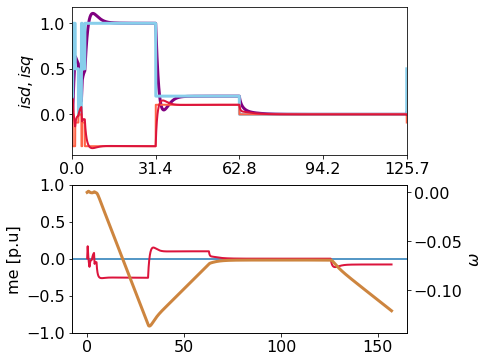

In [42]:
# a = 0.045
ml, a, isq = 0.0, 0.045, -0.35
# isdRef1, isqRef1 = calculateIsdIsqRefs(ml, a, isq)
# print(isdRef1, isqRef1)
# isdRef2, isqRef2 = calculateIsdIsqRefs(ml, 0.0, isqRef1)
# print(isdRef2, isqRef2)
# isdRef3, isqRef3 = calculateIsdIsqRefs(ml, -a, isqRef2)
# print(isdRef3, isqRef3)
# isdRef = np.array([isdRef1, isdRef2, isdRef3])
# isqRef = np.array([isqRef1, isqRef2, isqRef3])
# print(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
# Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration()

# print(w)
plotDynamicForSpeedingUp(Tta, w, me, isd, isq, isdref, isqref)

In [28]:
# def simulateSpeedingUpWithAcceleration(a):
#     #Setting up the simulaton for rotor model
#     # We will use for loop for simulation 
#     rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
#     tend = 20*2*np.pi
#     tstart = 0.0
#     delta_t = 0.01
#     Tta = np.arange(tstart, tend,delta_t)
#     # ODE solver parameters
#     abserr = 1.0e-8
#     relerr = 1.0e-3
    
#     n = 100000
# #     n2 = int(100*2*np.pi/0.01)
#     # ws = -0.5
#     ws = np.zeros(len(Tta))
#     # Initializing ws:
# #     a = 0.0001 # angular acceleration
#     for i in range(1, len(Tta)):
#         new_ws = ws[i-1]+a
#         if(new_ws > 1):
#             ws[i] = 1
#         else:
#             ws[i] = new_ws
#     mL = 0.0
#     # Tta = np.linspace(tstart, tend, n2)
#     #delta_t = Tta[1] - Tta[0]
#     usd = np.zeros(len(Tta))
#     usq = np.zeros(len(Tta))
#     sol1 = np.zeros((len(Tta),2))
#     # sol2 = np.zeros((len(Tta),2))
#     # FCangle = np.zeros(len(Tta))
#     # Field coordinate currents
#     cosdelta = np.zeros(len(Tta))
#     sindelta = np.zeros(len(Tta))
#     isd = np.zeros(len(Tta))
#     isq = np.zeros(len(Tta))
#     eid = np.zeros(len(Tta))
#     eiq = np.zeros(len(Tta))
#     w = np.zeros(len(Tta))

#     # psird = np.zeros(len(Tta))
#     # psirq = np.zeros(len(Tta))

#     # # Initializing reference values for isd and isq:
#     isdrefval = -0.1
#     isdref = np.zeros(len(Tta))
#     isqref = np.zeros(len(Tta))

#     isqref1 = 0.0
#     isqref2 = 0.8
#     isqref3 = -0.35
#     for ii in range(len(Tta)):
#         isdref[ii] = 0.0
#         if (Tta[ii]>=10*2*np.pi):
#             isqref[ii] = isqref3
#             isdref[ii] = -isdrefval
#         elif(Tta[ii]>=1*2*np.pi):
#             isqref[ii]=isqref2
#             isdref[ii] = isdrefval
#         else:
#             isqref[ii]=isqref1

#     me = np.zeros(len(Tta))
#     x0 = [0,0] # isd, isq, ws
#     y0 = [1.0,0]

#     kpd = ld*1
#     Tid = 25.0e1

#     kpq = lq*2
#     Tiq = 25.0e1

#     Kparamsd = [kpd,Tid]
#     Kparamsq = [kpq,Tiq]

#     for ii in range(len(Tta)):
#         #Start controller after first step
#         if ii>=0:
#             eid[ii] = isdref[ii-1] - isd[ii-1]
#             PIed = [eid[ii],eid[ii-1]]
#             usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#             eiq[ii] = isqref[ii-1] - isq[ii-1]
#             PIeq = [eiq[ii],eiq[ii-1]]
#             usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

#         # solve for the state variables: isd, isq
#         params = [usd[ii], usq[ii],w[ii], ws[ii]]
#         sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#         sol1[ii]= sol1a[-1]
#         x0 = sol1a[-1]
#         isd[ii] = sol1[ii][0]
#         isq[ii] = sol1[ii][1]


#     #rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
#     rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
#     return Tta, ws, me, isd, isq

In [29]:
def calculateIsdIsqRefs(ml, a, isq):
    rs,ld,lq, tmech, psirm = mach_para(mach_mc)
    isqOrig = isq
    while((psi_rm+(ld-lq)*isq) == 0 and isq >= -1 and isq <= 1):
        isq -= 0.001
    if((psi_rm+(ld-lq)*isq) != 0):
        isd = tmech*(a+ml)/(psi_rm+(ld-lq)*isq)
    else:
        isq = isqOrig
        while((psi_rm+(ld-lq)*isq) == 0 and isq >= -1 and isq <= 1):
            isq += 0.001
        if((psi_rm+(ld-lq)*isq) != 0):
            isd = tmech*(a+ml)/(psi_rm+(ld-lq)*isq)
    if((psi_rm+(ld-lq)*isq) == 0):
        isd, isq = -2, -2 # No solotion
    return isd, isq

In [30]:
a = 0.001
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

TypeError: simulateSpeedingUpWithAcceleration() takes 0 positional arguments but 1 was given

In [ ]:
a = 0.0005
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

In [ ]:
a = 0.0002
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

In [ ]:
a = 0.00015
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

In [ ]:
a = 0.0001
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

In [ ]:
a = 0.00009
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

The undershoot of torque decreases significantly when $\omega_s$ is lower than 0.0001. 